<a href="https://colab.research.google.com/github/liballouo/Mahjong/blob/main/Kong_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
torch.cuda.is_available()

True

# Mount Google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataloader

In [4]:
class ExampleDataset(Dataset):
    def __init__(self):
        # integer inputs
        # file_name = '/content/drive/MyDrive/專題/Kong_reward_hand_only_0_1.csv'
        # float inputs
        # file_name = '/content/drive/MyDrive/專題/Kong_reward_hand_only.csv'
        file_name = '/content/drive/MyDrive/專題/Kong_reward_extended_hand_only.csv'

        df = pd.read_csv(file_name)

        xy = df.to_numpy()

        for i in range(len(xy)):
            for j in range(len(xy[i])):
                xy[i][j] = np.array(eval(xy[i][j]))

        x = xy[:, :-1]
        y = xy[:, -1:]

        test_tensor = []
        test_tensor.append(torch.tensor([list(arr) for arr in x]))

        flatten_tensor = torch.tensor([list(arr) for arr in x])

        # for i in range(len(test_tensor)):
        #     torch.flatten(flatten_tensor[i])

        tensor_y = torch.tensor([list(arr) for arr in y])

        x = flatten_tensor

        # Reshape input x to have dimensions (batch_size, 2, 34)
        # print(x.shape)
        x = x.reshape(-1, 2, 34)
        # print(x.shape)

        # float inputs
        self.x = torch.tensor(x, dtype=torch.float32)
        # integer inputs
        # self.x = torch.tensor(x, dtype=torch.int32)

        self.y = tensor_y
        self.y = tensor_y.squeeze(1)  # Reshape label tensor to remove the extra dimension

        self.n_samples = xy.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples


In [5]:
dataset = ExampleDataset()

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# print(len(dataset))

<ipython-input-4-61cdbba8c822>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  test_tensor.append(torch.tensor([list(arr) for arr in x]))
<ipython-input-4-61cdbba8c822>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)


In [6]:
print(len(dataset.x))

65310


# Split data

In [7]:
# Random split
# length of training set
training_set_size = int(len(dataset) * 0.8)
# length of test set
test_set_size = len(dataset) - training_set_size
training_set, test_set = random_split(dataset, [training_set_size, test_set_size])

training_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

print(len(training_dataloader))
print(len(test_dataloader))

1633
409


# Model

In [8]:
class Majhong_Model(nn.Module):
    def __init__(self):
        super(Majhong_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.conv_last = nn.Conv1d(in_channels=256, out_channels=32, kernel_size=3, stride=1)
        # self.fc = nn.Linear(32*34, 1024)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size = x.size(0)
        out = self.conv1(x)
        out = self.relu(out)
        for i in range(2):
          out = self.conv2(out)
          out = self.relu(out)

        out = self.conv_last(out)
        out = self.relu(out)
        out = out.view(batch_size, -1)  # Flatten the output of convolutional layer
        # out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out


# Model initiation

In [9]:
model = Majhong_Model()
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Test

In [ ]:
def test(net, testLoader, criterion, show=False):
  net.eval()
  totalLoss = 0.0
  accuracy = 0.0
  count = 0
  for x, label in testLoader:
    x = x.to(device, dtype=torch.float32)
    label = label.to(device, dtype=torch.float32)
    output = net(x)
    loss = criterion(output, label)
    _, predicted = torch.max(output.data, dim=1)
    check_label = torch.Tensor()
    check_label = torch.argmax(label, dim=1)
    count += len(x)
    accuracy += (predicted == check_label).sum().item()
    totalLoss += loss.item()*len(label)
  if show == True:
    print("Test Loss: {}".format(totalLoss / count))
    print("Test Accuracy: {}".format(accuracy / count))
  return (totalLoss / count, accuracy / count)


# Test (confusion matrix)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def test(net, testLoader, criterion, show=False):
    net.eval()
    totalLoss = 0
    correct = 0
    count = 0
    all_predicted = []
    all_true = []

    for x, label in testLoader:
        x = x.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.float32)
        output = net(x)
        print(output)
        loss = criterion(output, label)
        _, predicted = torch.max(output.data, 1)
        check_label = torch.Tensor()
        check_label = torch.argmax(label, dim=1)

        count += len(x)
        correct += (predicted == check_label).sum().item()
        totalLoss += loss.item() * len(label)

        all_predicted.extend(predicted.tolist())
        all_true.extend(check_label.tolist())

    # Compute the confusion matrix
    cm = confusion_matrix(all_true, all_predicted)

    # Calculate accuracy
    accuracy = correct / count

    if show == True:
      print("Test Loss: {:.4f}".format(totalLoss / count))
      print("Test Accuracy: {:.2f}%".format(accuracy * 100))

    # Create a heatmap using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    # Add labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the chart
    plt.show()
    print('Accuracy :' + str(accuracy * 100) +'%')
    return (totalLoss / count, accuracy)



# Training model

Epoch 1/50, Loss: 1.3509666919708252


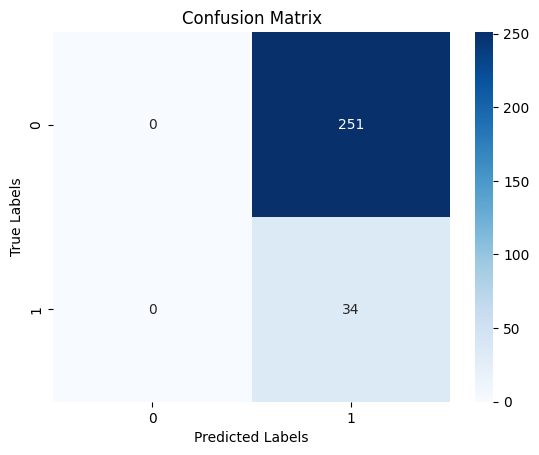

Epoch 2/50, Loss: 1.2491512298583984


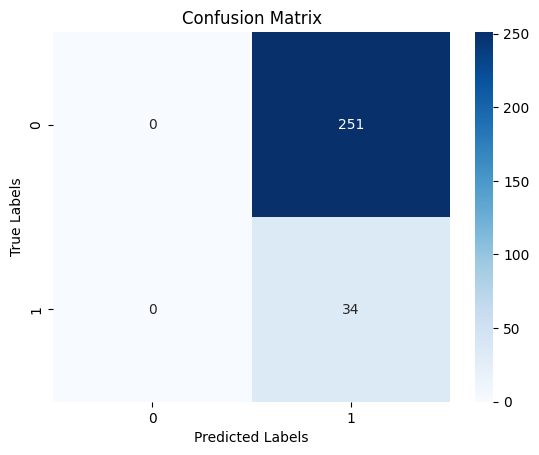

Epoch 3/50, Loss: 1.2818645238876343


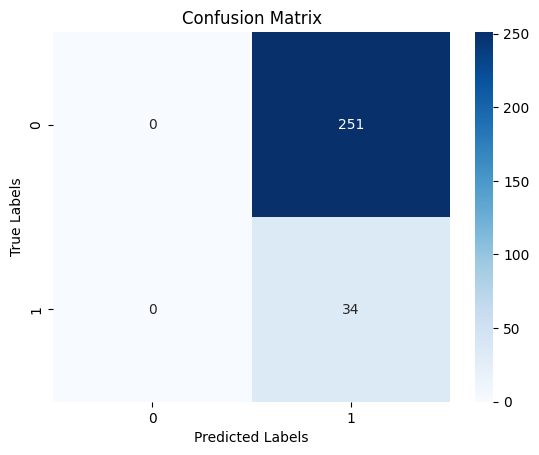

Epoch 4/50, Loss: 1.101981520652771


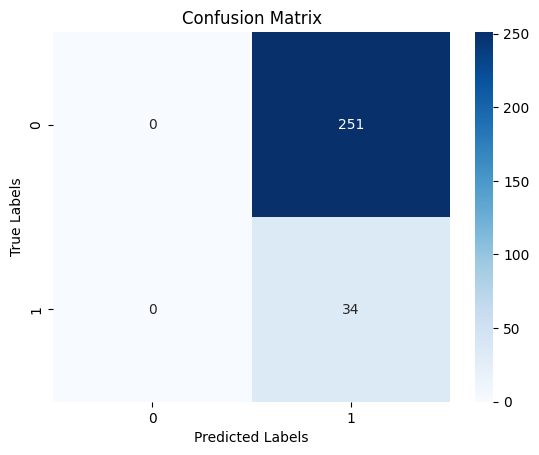

Epoch 5/50, Loss: 1.2483932971954346


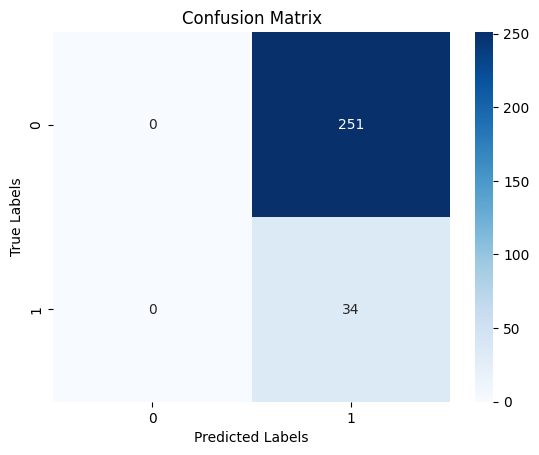

Epoch 6/50, Loss: 1.2529940605163574


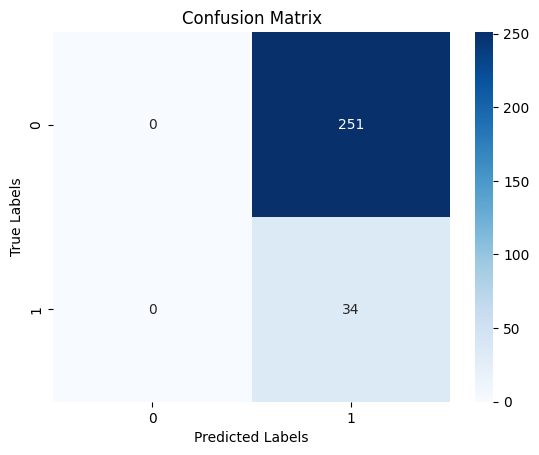

Epoch 7/50, Loss: 1.2805302143096924


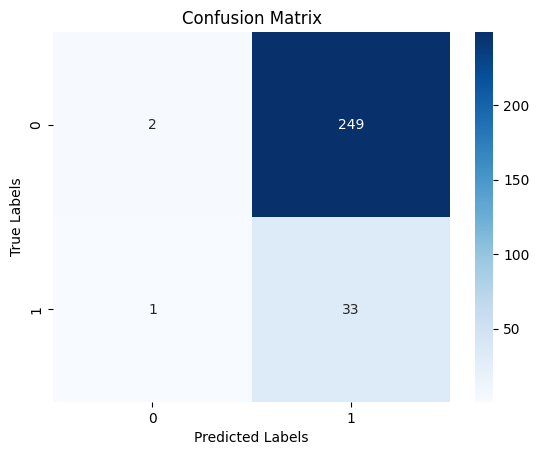

Epoch 8/50, Loss: 1.1763149499893188


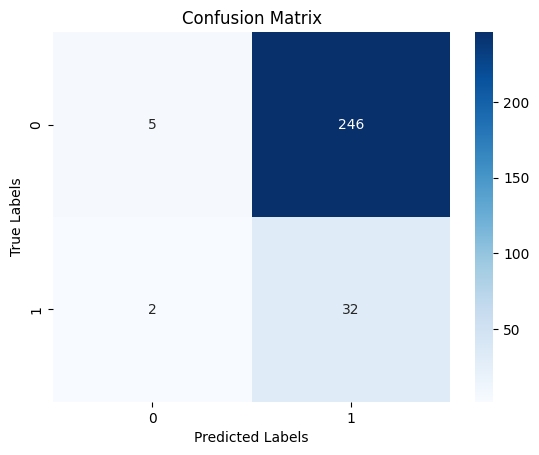

Epoch 9/50, Loss: 1.2463990449905396


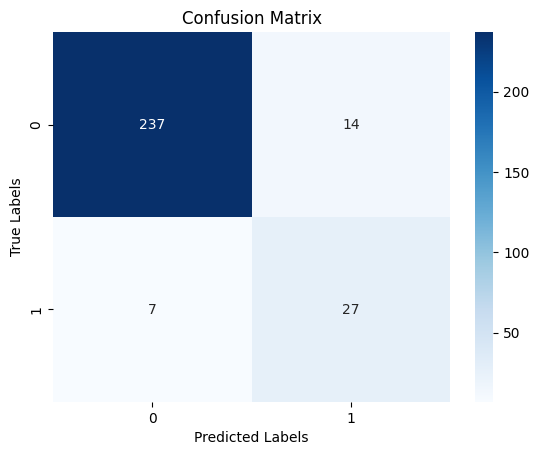

Epoch 10/50, Loss: 1.1708632707595825


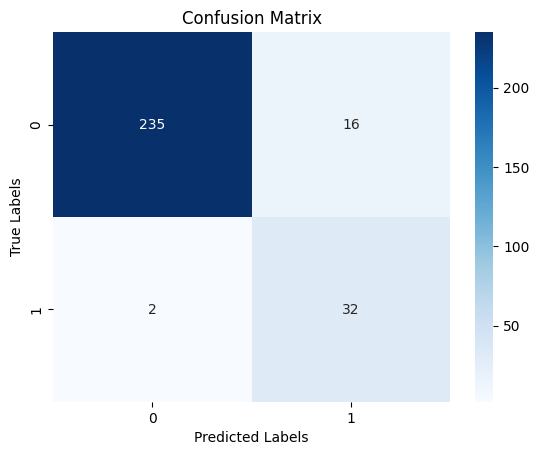

Epoch 11/50, Loss: 1.020187497138977


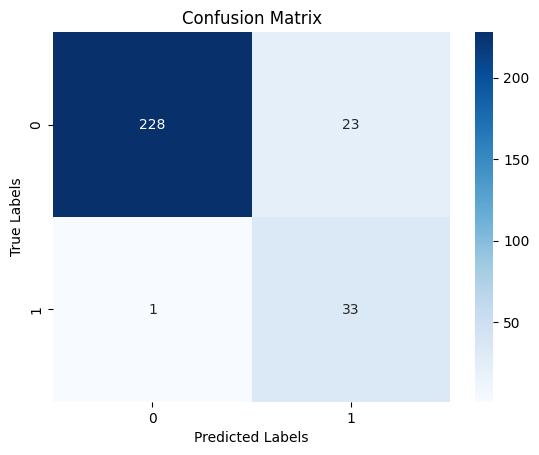

Epoch 12/50, Loss: 1.336416244506836


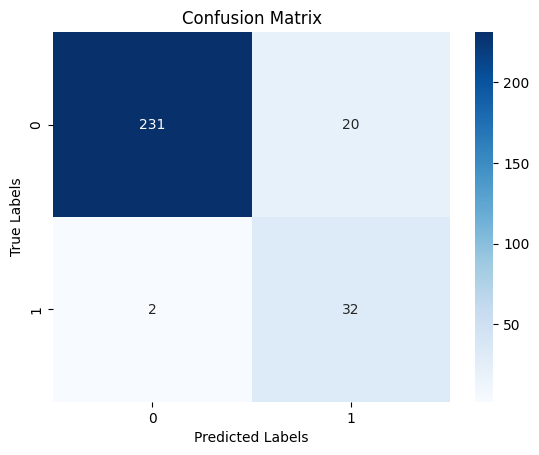

Epoch 13/50, Loss: 1.2266385555267334


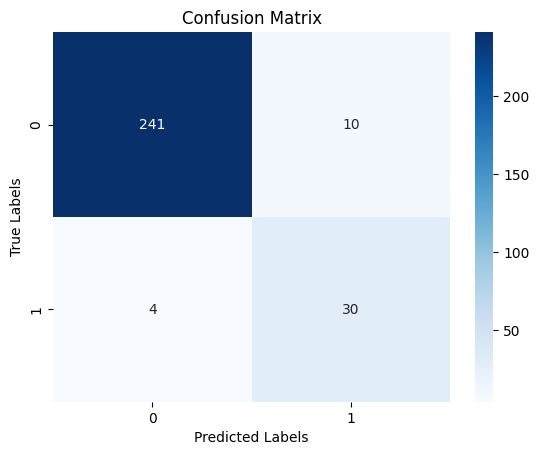

Epoch 14/50, Loss: 1.1206731796264648


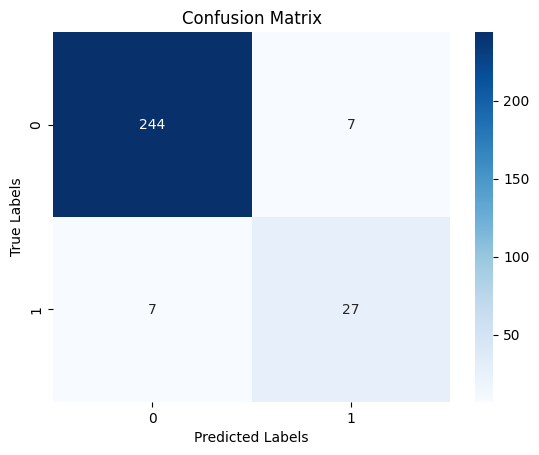

Epoch 15/50, Loss: 1.0914000272750854


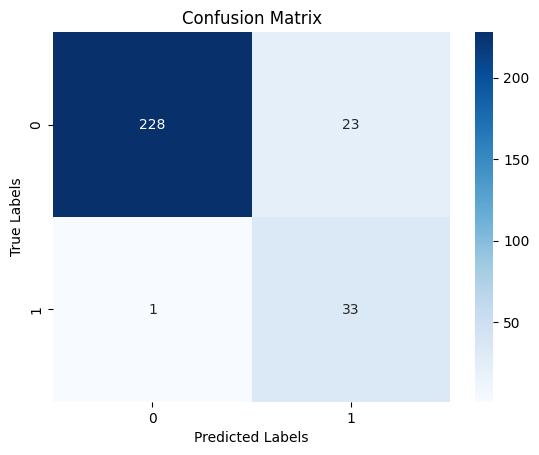

Epoch 16/50, Loss: 1.1907777786254883


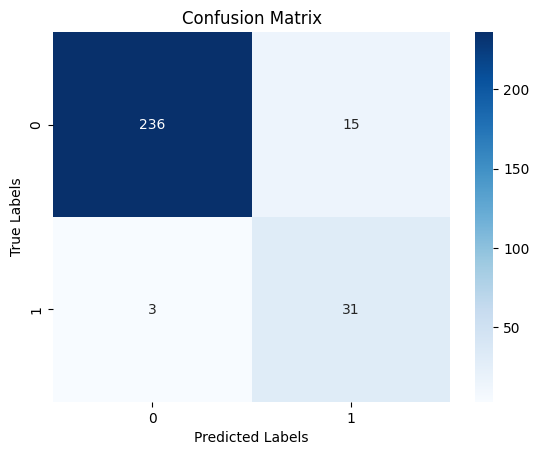

Epoch 17/50, Loss: 1.3106516599655151


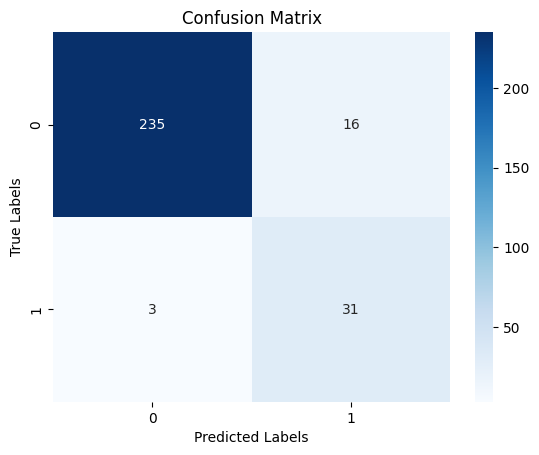

Epoch 18/50, Loss: 1.1873236894607544


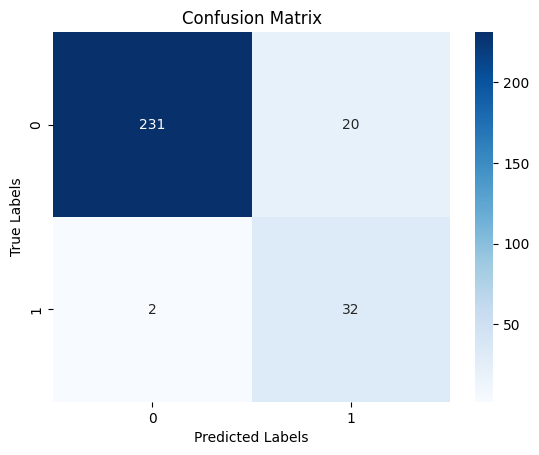

Epoch 19/50, Loss: 1.1671072244644165


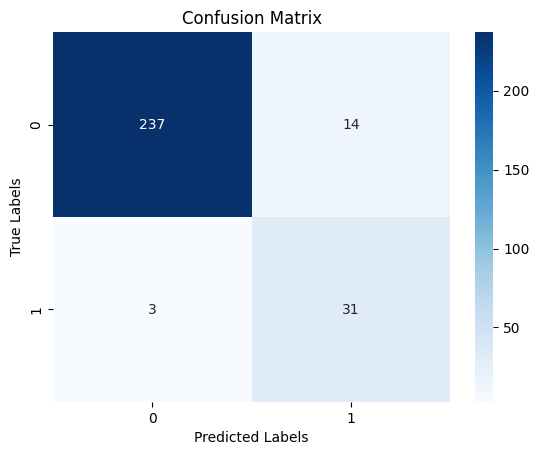

Epoch 20/50, Loss: 1.0138647556304932


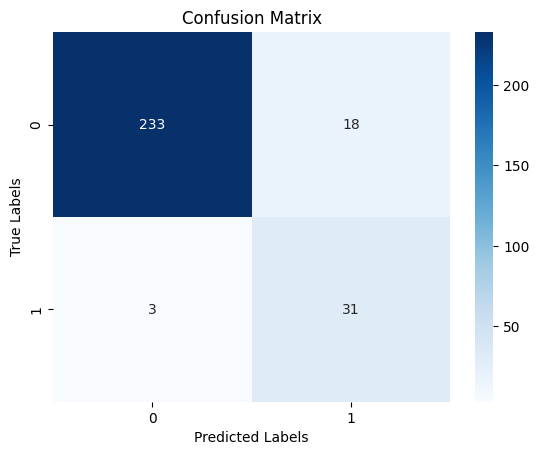

Epoch 21/50, Loss: 1.2466011047363281


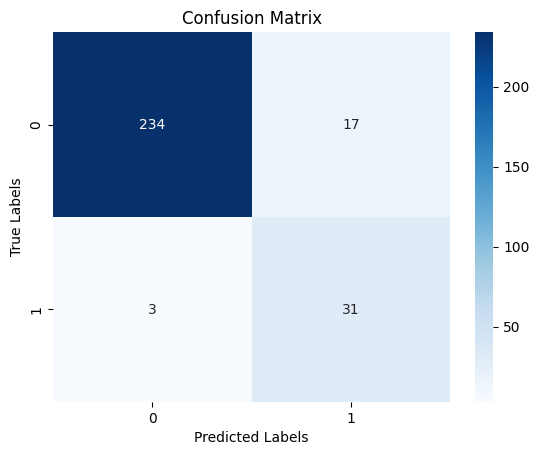

Epoch 22/50, Loss: 1.2575362920761108


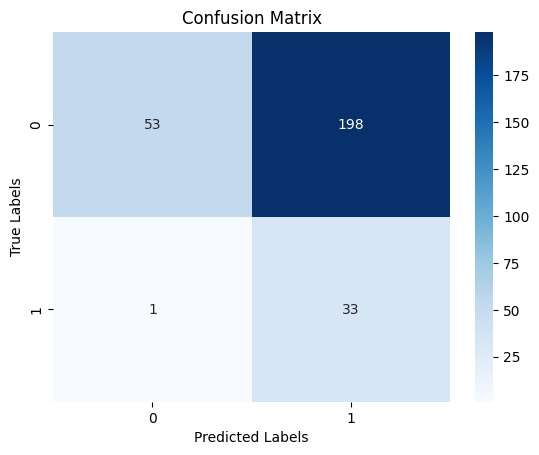

Epoch 23/50, Loss: 1.0330564975738525


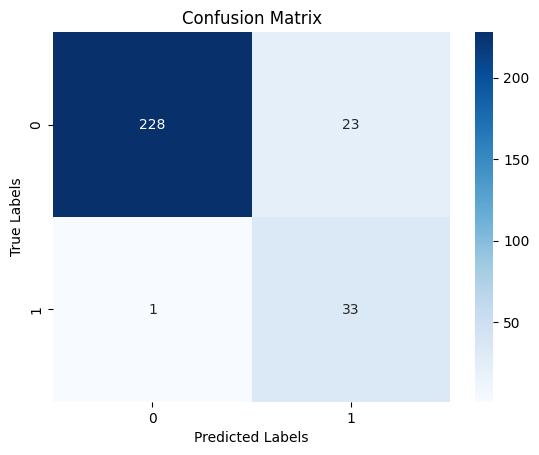

Epoch 24/50, Loss: 1.2663758993148804


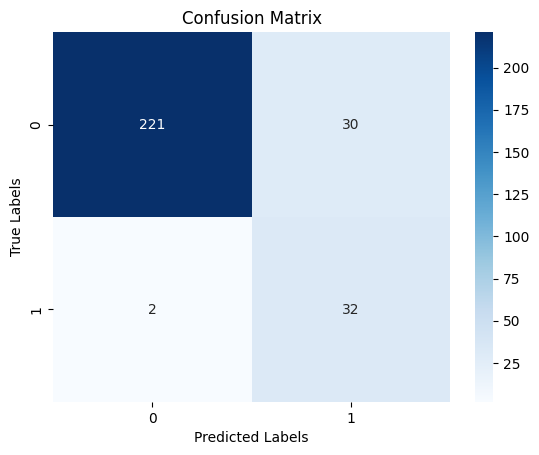

Epoch 25/50, Loss: 1.1548937559127808


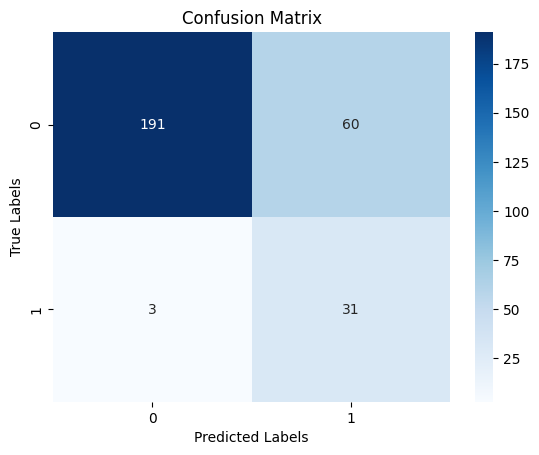

Epoch 26/50, Loss: 1.0633044242858887


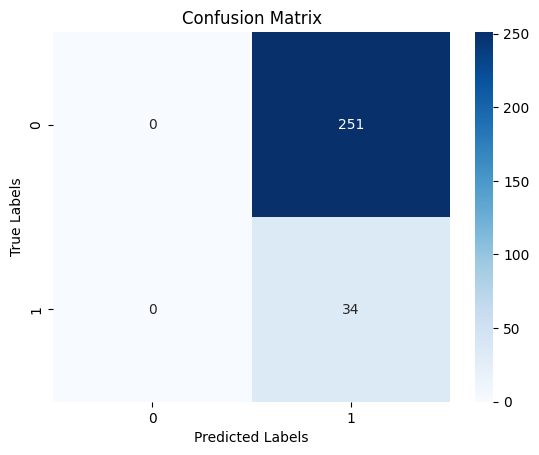

Epoch 27/50, Loss: 1.2992838621139526


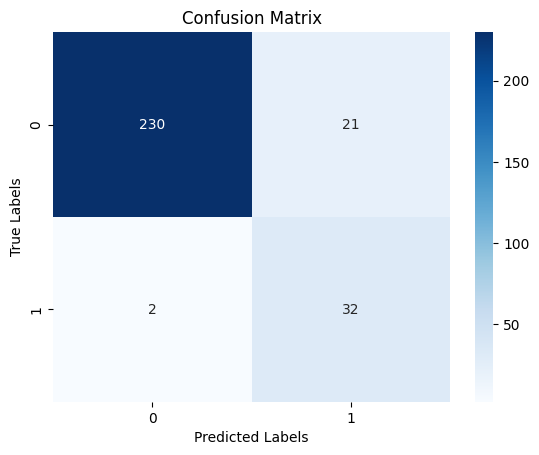

Epoch 28/50, Loss: 1.0965970754623413


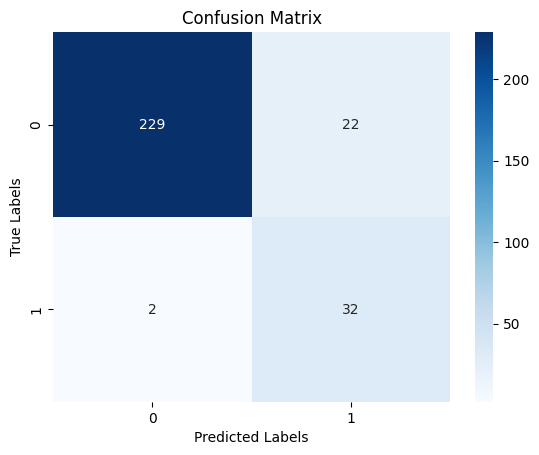

Epoch 29/50, Loss: 1.2362498044967651


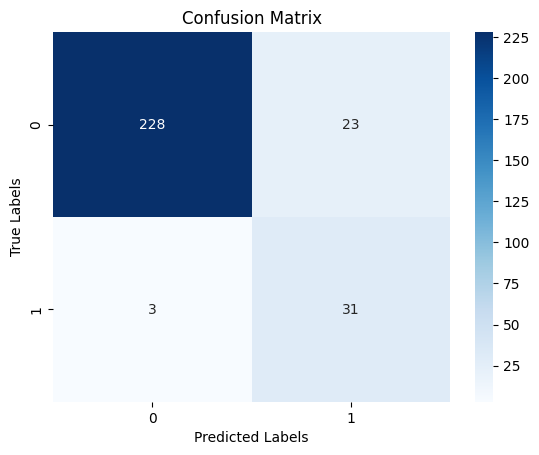

Epoch 30/50, Loss: 1.242427110671997


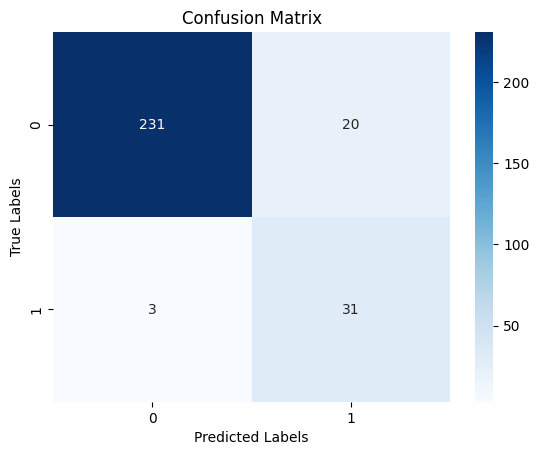

Epoch 31/50, Loss: 1.1953508853912354


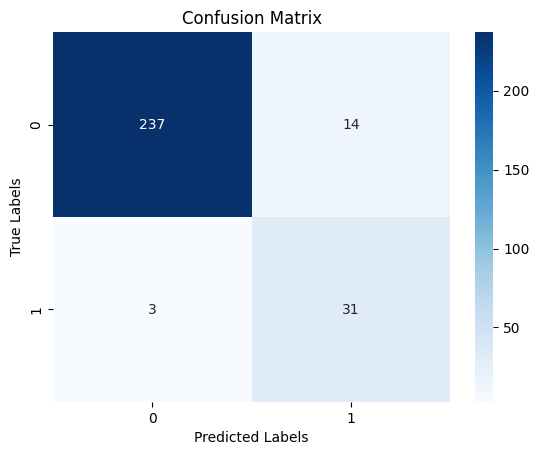

Epoch 32/50, Loss: 1.2440658807754517


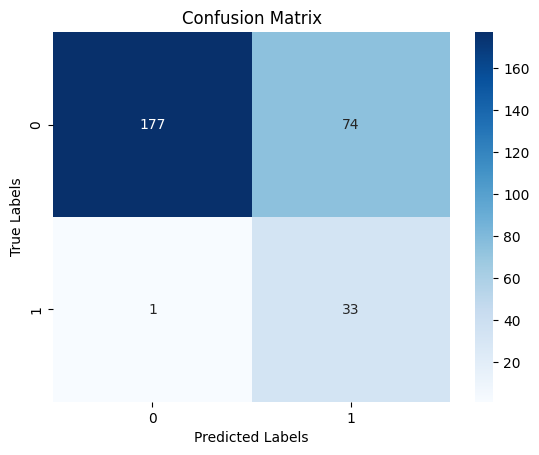

Epoch 33/50, Loss: 1.316459059715271


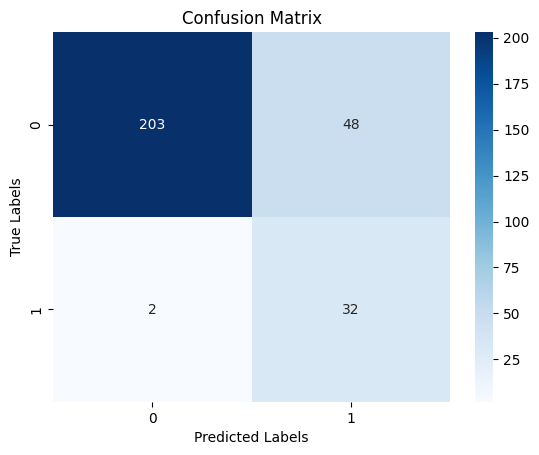

Epoch 34/50, Loss: 1.280983328819275


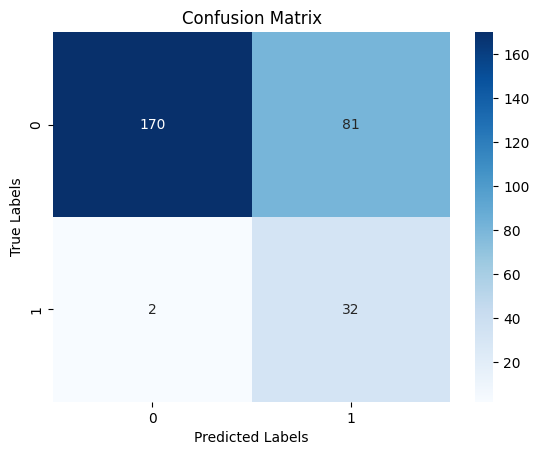

Epoch 35/50, Loss: 1.2265218496322632


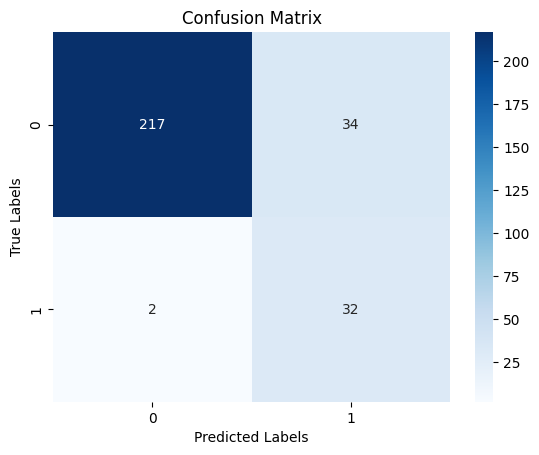

Epoch 36/50, Loss: 1.377028465270996


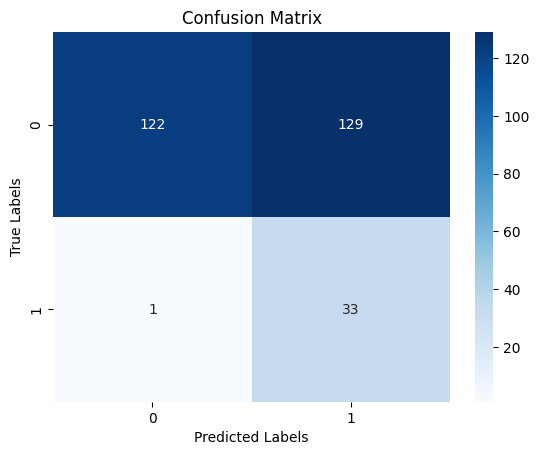

Epoch 37/50, Loss: 1.1611419916152954


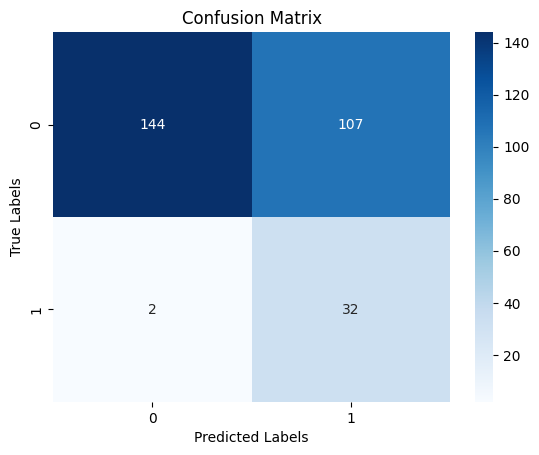

Epoch 38/50, Loss: 1.238149642944336


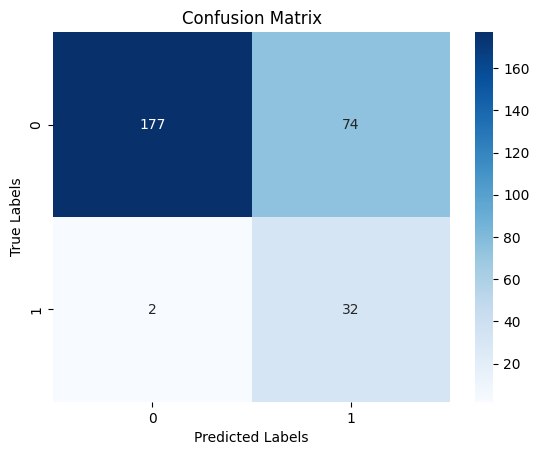

Epoch 39/50, Loss: 1.1490010023117065


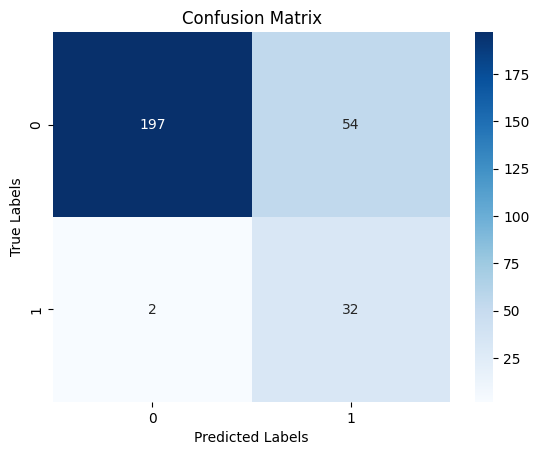

Epoch 40/50, Loss: 1.3489429950714111


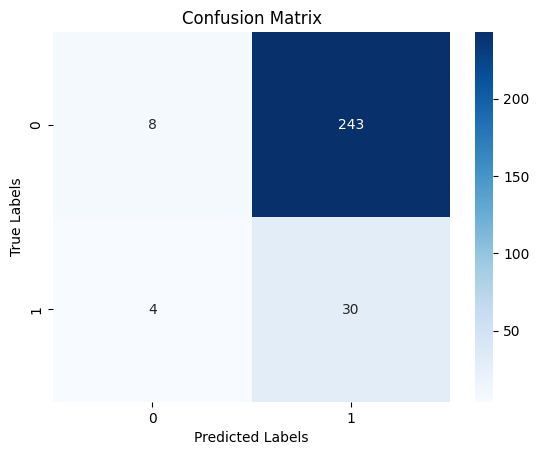

Epoch 41/50, Loss: 1.1021655797958374


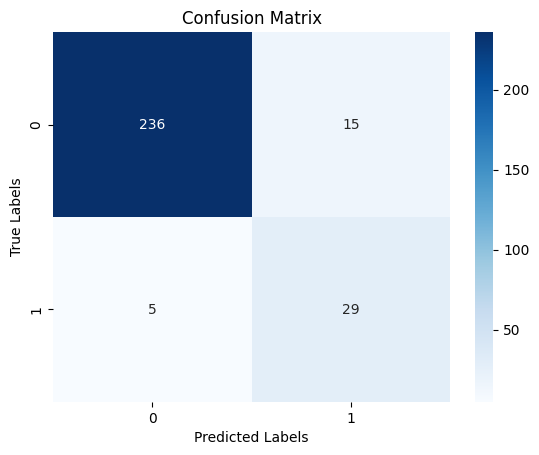

Epoch 42/50, Loss: 1.0731092691421509


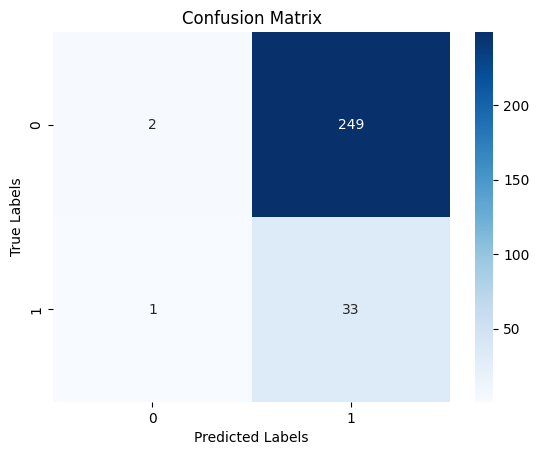

Epoch 43/50, Loss: 1.2282121181488037


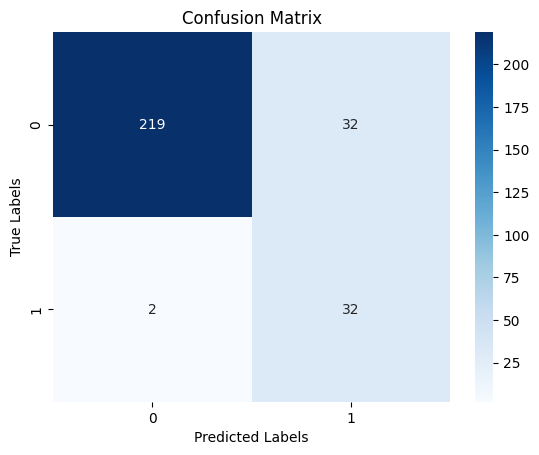

Epoch 44/50, Loss: 1.2010496854782104


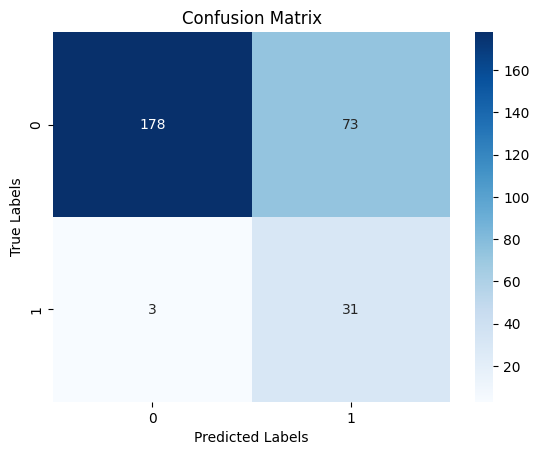

Epoch 45/50, Loss: 1.2310304641723633


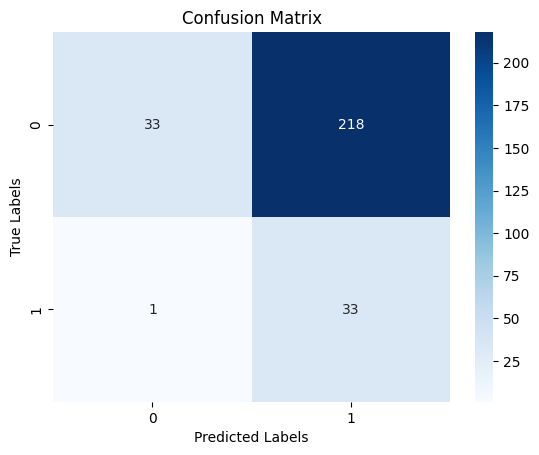

Epoch 46/50, Loss: 1.1424130201339722


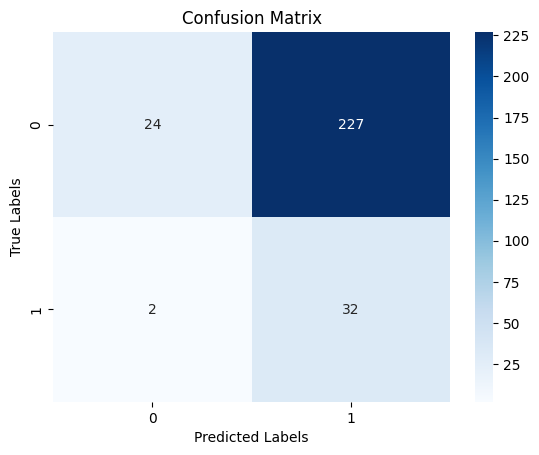

Epoch 47/50, Loss: 1.2005336284637451


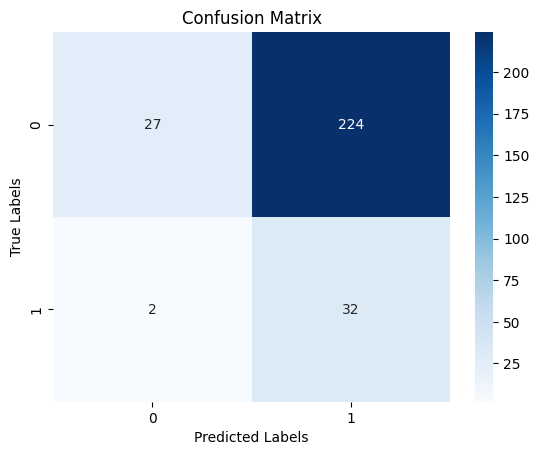

Epoch 48/50, Loss: 1.3107837438583374


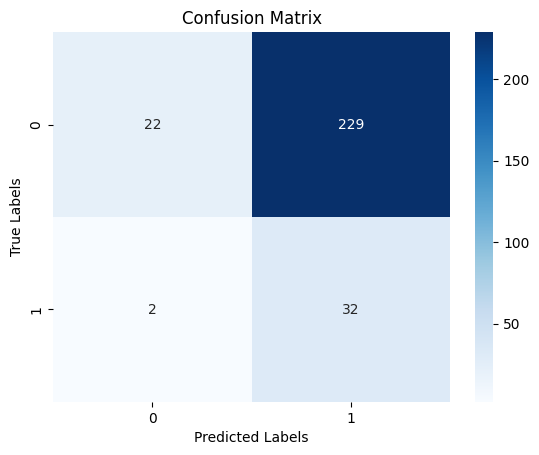

Epoch 49/50, Loss: 1.0953420400619507


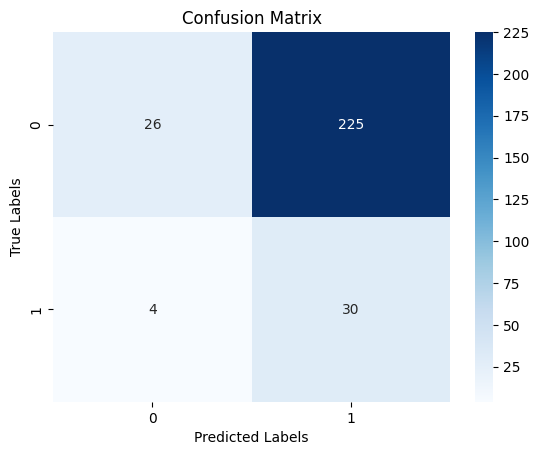

Epoch 50/50, Loss: 1.2415332794189453


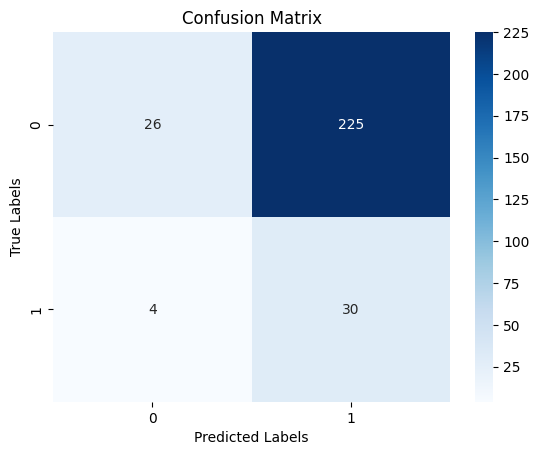

In [ ]:
plot_accuracy = []
plot_loss = []

num_epochs = 50

for epoch in range(num_epochs):
    for inputs, targets in training_dataloader:
      inputs = inputs.to(torch.float32).to(device)
      targets = targets.to(torch.float32).to(device)
      # Forward pass
      outputs = model(inputs)

      # Reshape the target tensor
      targets = targets.view(-1, 2)

      # print(outputs)

      # Compute the loss
      loss = criterion(outputs, targets)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    round_loss, round_accuracy = test(model, test_dataloader, criterion)
    plot_loss.append(round_loss)
    plot_accuracy.append(round_accuracy)


# Check best model

串流輸出內容已截斷至最後 5000 行。
        [0.5015, 0.4985],
        [0.5015, 0.4985]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[0.5015, 0.4985],
        [0.0551, 0.9449],
        [0.5125, 0.4875],
        [0.8337, 0.1663],
        [0.5094, 0.4906],
        [0.0607, 0.9393],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.5155, 0.4845],
        [0.5015, 0.4985],
        [0.8326, 0.1674],
        [0.5015, 0.4985],
        [0.0785, 0.9215],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.5736, 0.4264],
        [0.5015, 0.4985],
        [0.5167, 0.4833],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.5015, 0.4985],
        [0.6670, 0.3330],
        [0.5006, 0.4994],
        [0.5015, 0.4985],
        [0.4379, 0.5621]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
ten

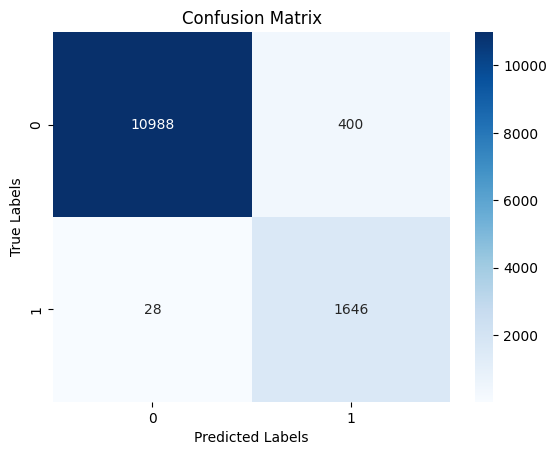

Accuracy :96.72331955290154%


In [11]:
best_model = torch.load('/content/drive/MyDrive/專題/Kong model/best_model.pth')

model = Majhong_Model()
model.load_state_dict(best_model['model_state_dict'])

model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.load_state_dict(best_model['optimizer_state_dict'])

model.eval()

_, best_accuracy = test(model, test_dataloader, criterion)

In [ ]:
print(best_accuracy)

0.8324911958352473


# Training model (save model)

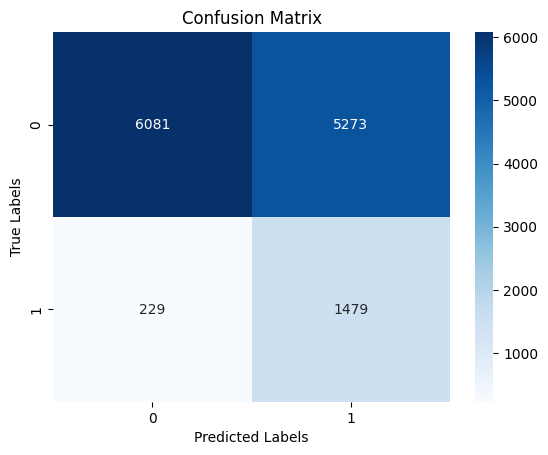

Accuracy :57.87781350482315%
Epoch 1/150, Loss: 0.6904250383377075


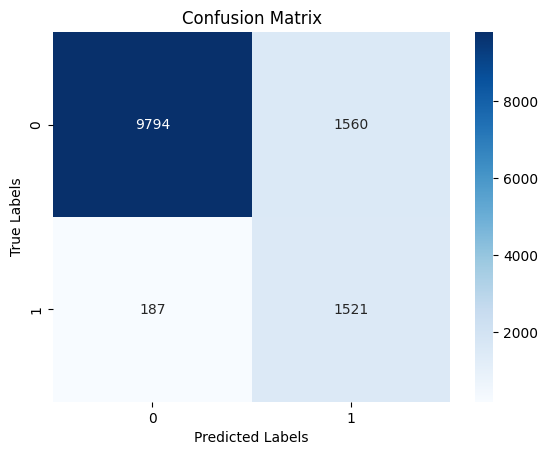

Accuracy :86.62532537130609%
Epoch 2/150, Loss: 0.6931475400924683
Best model saved, epoch = 2.


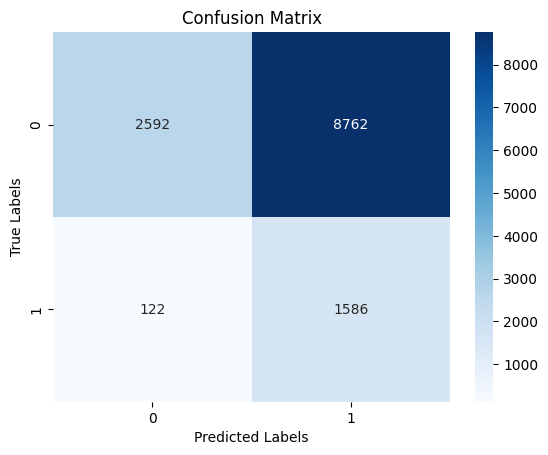

Accuracy :31.98591333639565%
Epoch 3/150, Loss: 0.6855494379997253


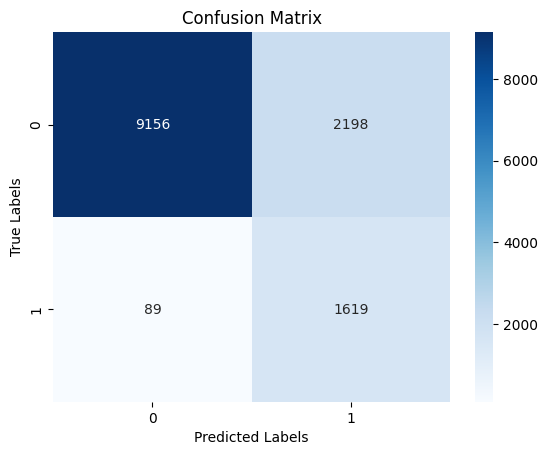

Accuracy :82.49119583524728%
Epoch 4/150, Loss: 0.6930939555168152


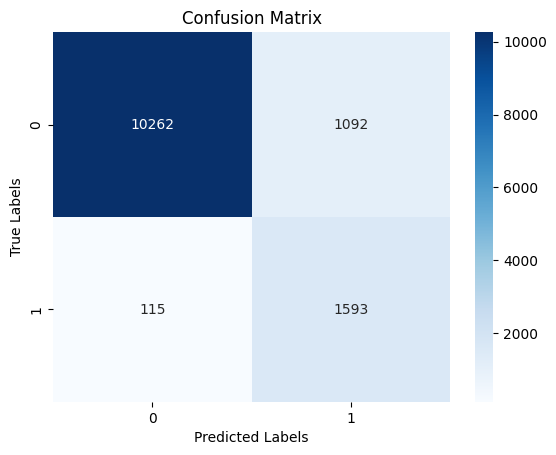

Accuracy :90.75945490736488%
Epoch 5/150, Loss: 0.6892694234848022
Best model saved, epoch = 5.


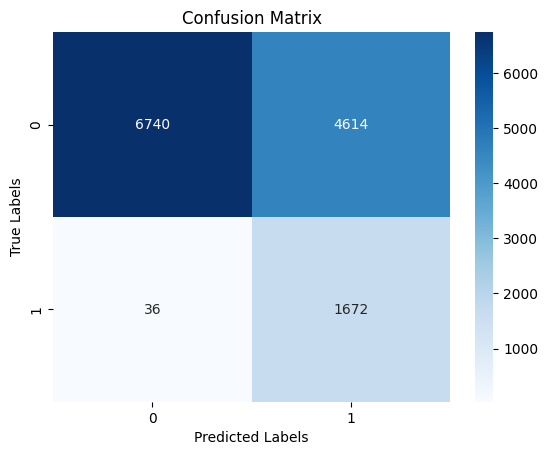

Accuracy :64.40055121727147%
Epoch 6/150, Loss: 0.6816157698631287


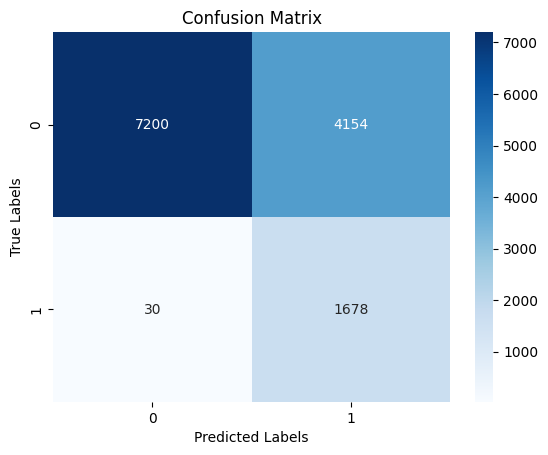

Accuracy :67.96815189098147%
Epoch 7/150, Loss: 0.693187415599823


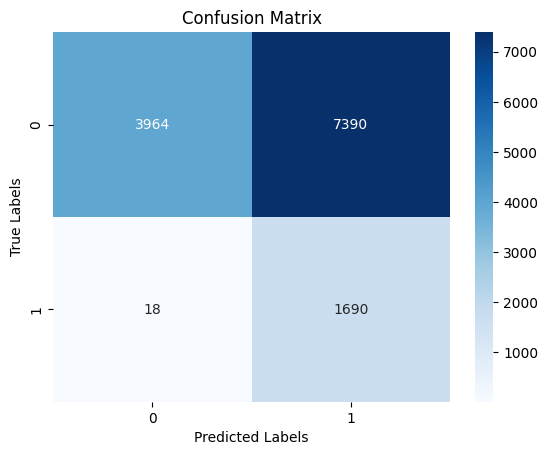

Accuracy :43.28586740162303%
Epoch 8/150, Loss: 0.6928273439407349


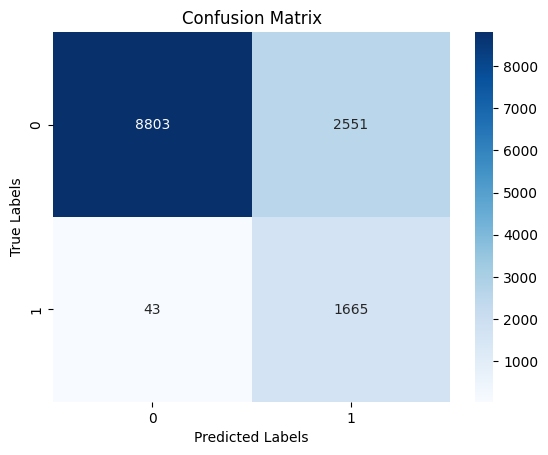

Accuracy :80.14086663604348%
Epoch 9/150, Loss: 0.6891977787017822


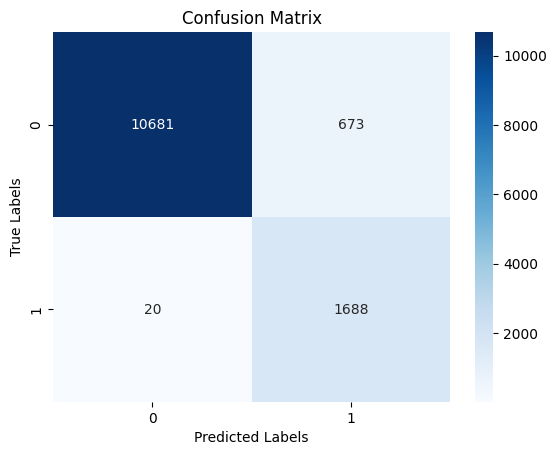

Accuracy :94.69453376205787%
Epoch 10/150, Loss: 0.6858741641044617
Best model saved, epoch = 10.


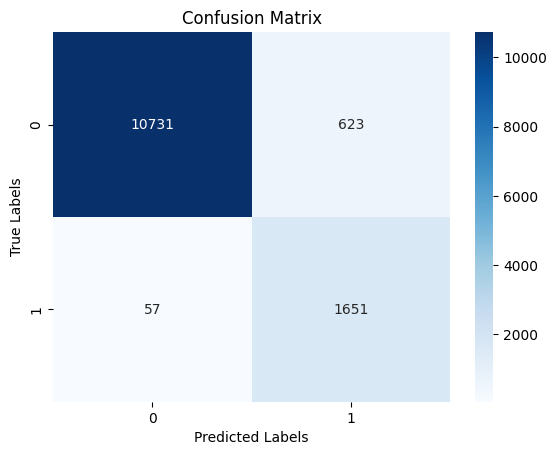

Accuracy :94.79405910274077%
Epoch 11/150, Loss: 0.6898571252822876
Best model saved, epoch = 11.


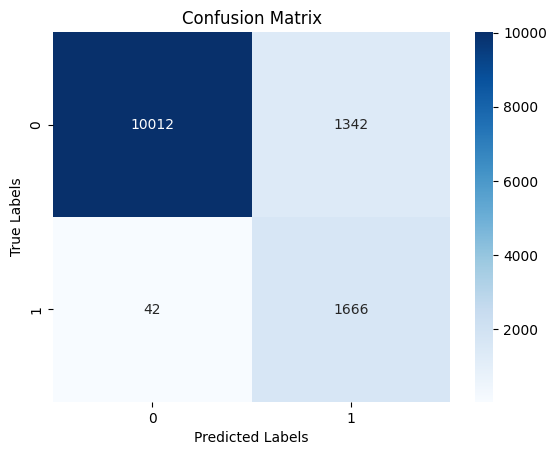

Accuracy :89.40437911499005%
Epoch 12/150, Loss: 0.6892778873443604


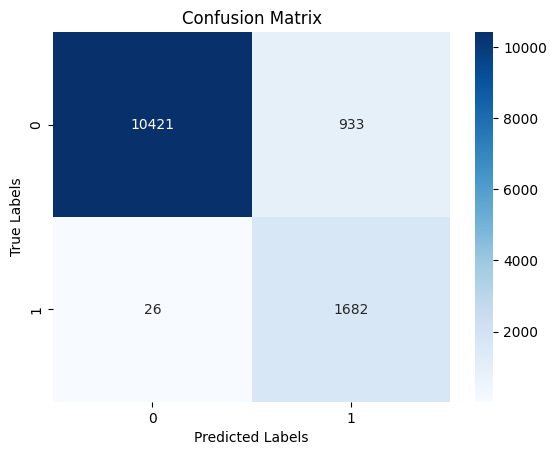

Accuracy :92.65809217577706%
Epoch 13/150, Loss: 0.687606692314148


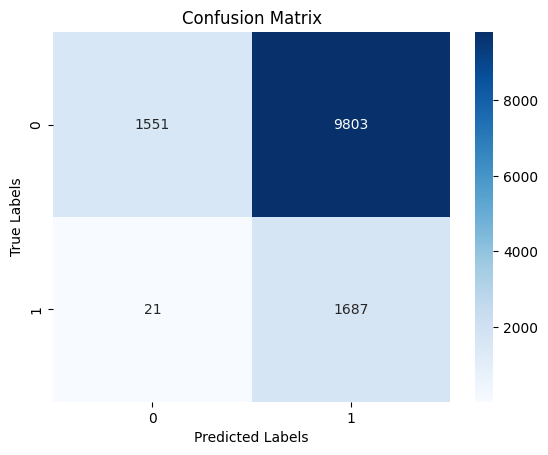

Accuracy :24.78946562547849%
Epoch 14/150, Loss: 0.6845201253890991


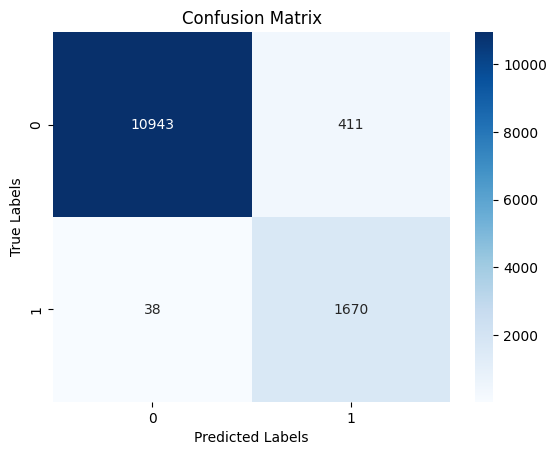

Accuracy :96.56254784872148%
Epoch 15/150, Loss: 0.6931325793266296
Best model saved, epoch = 15.


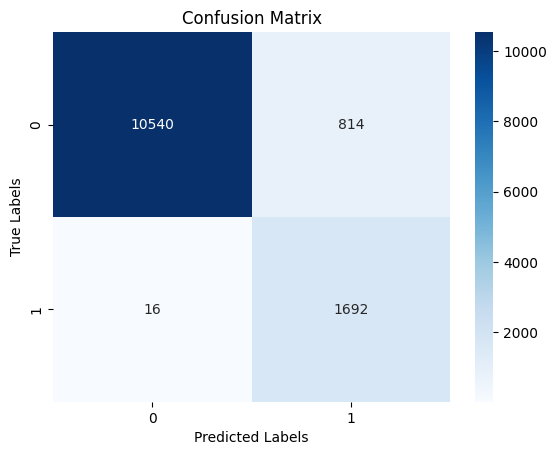

Accuracy :93.64568978716889%
Epoch 16/150, Loss: 0.6858816146850586


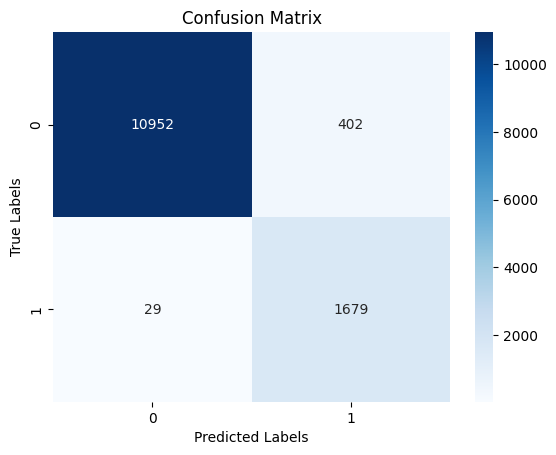

Accuracy :96.70035216659011%
Epoch 17/150, Loss: 0.6930503845214844
Best model saved, epoch = 17.


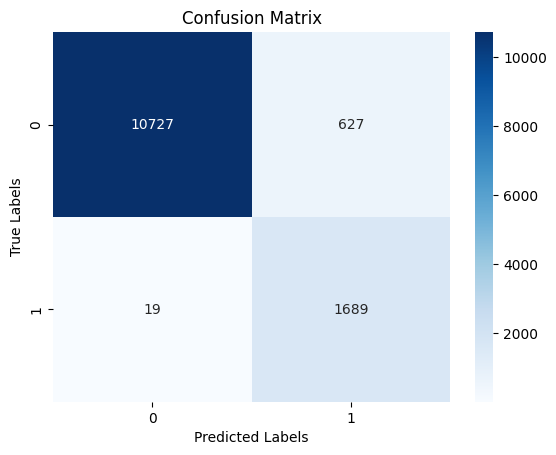

Accuracy :95.05435614760374%
Epoch 18/150, Loss: 0.6864010095596313


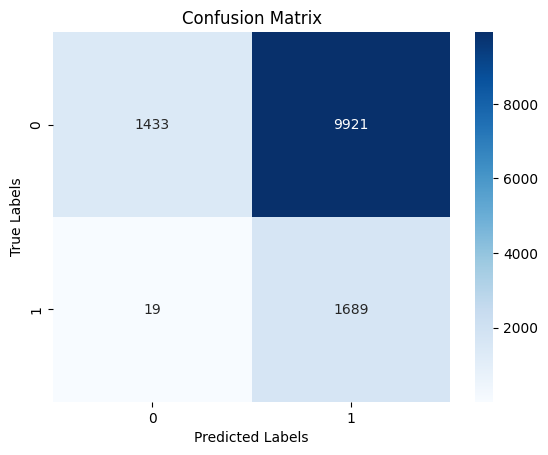

Accuracy :23.90139335476956%
Epoch 19/150, Loss: 0.6891472339630127


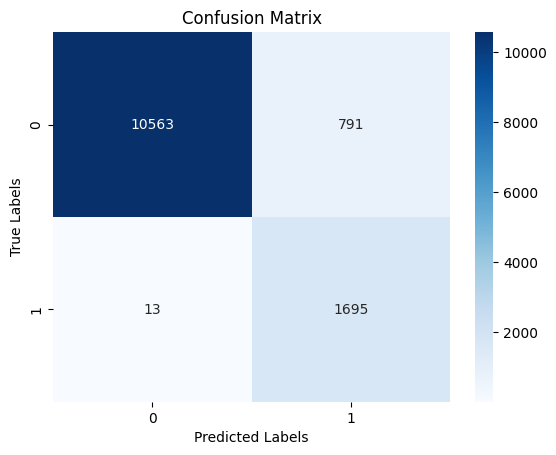

Accuracy :93.84474046853468%
Epoch 20/150, Loss: 0.6895422339439392


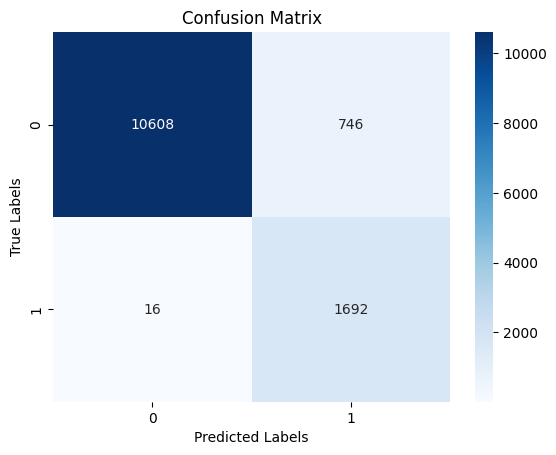

Accuracy :94.16628387689481%
Epoch 21/150, Loss: 0.6894699931144714


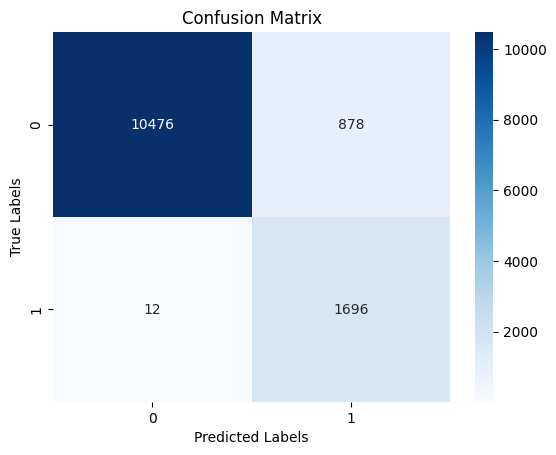

Accuracy :93.18634206094013%
Epoch 22/150, Loss: 0.6868907809257507


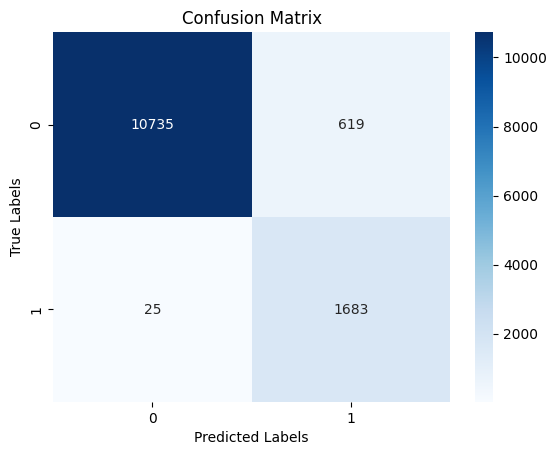

Accuracy :95.06966773847803%
Epoch 23/150, Loss: 0.690617561340332


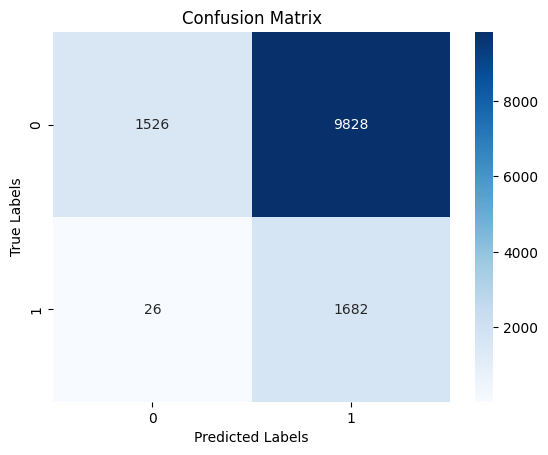

Accuracy :24.55979176236411%
Epoch 24/150, Loss: 0.6929953098297119


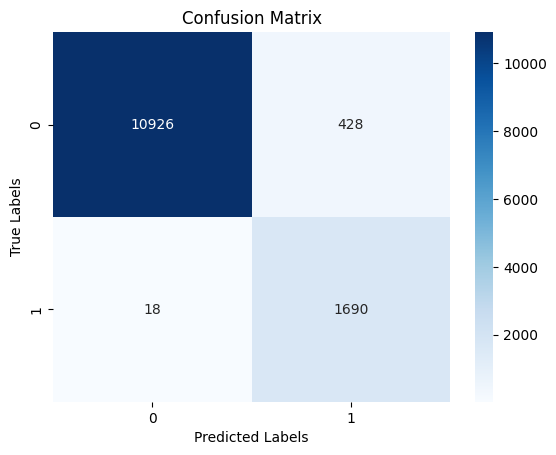

Accuracy :96.58551523503291%
Epoch 25/150, Loss: 0.6807162165641785


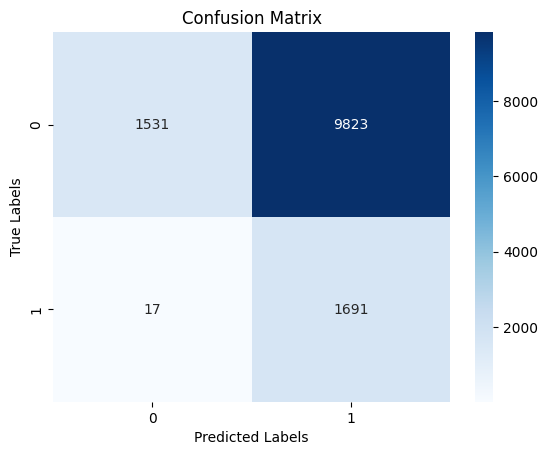

Accuracy :24.66697289848415%
Epoch 26/150, Loss: 0.689166784286499


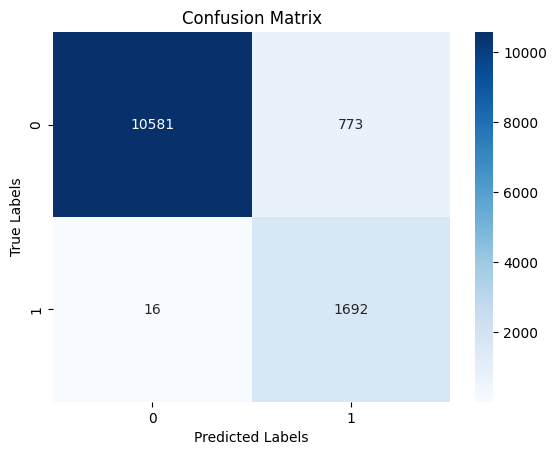

Accuracy :93.95957740009186%
Epoch 27/150, Loss: 0.6907269358634949


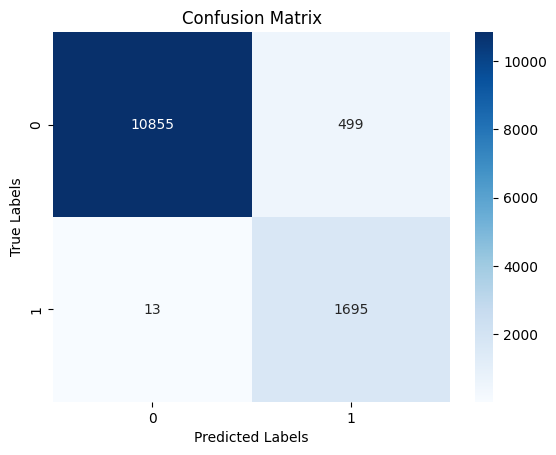

Accuracy :96.08023273618129%
Epoch 28/150, Loss: 0.6898583769798279


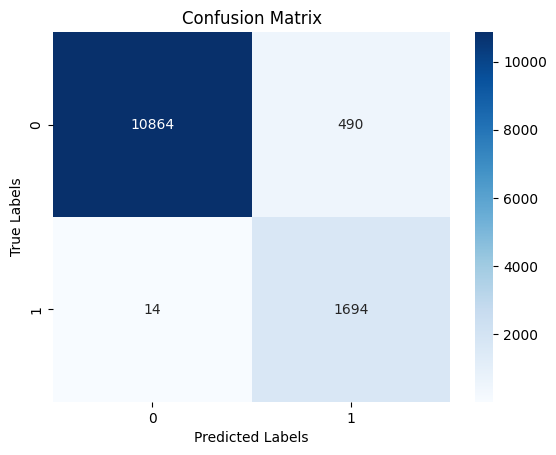

Accuracy :96.14147909967846%
Epoch 29/150, Loss: 0.6835352778434753


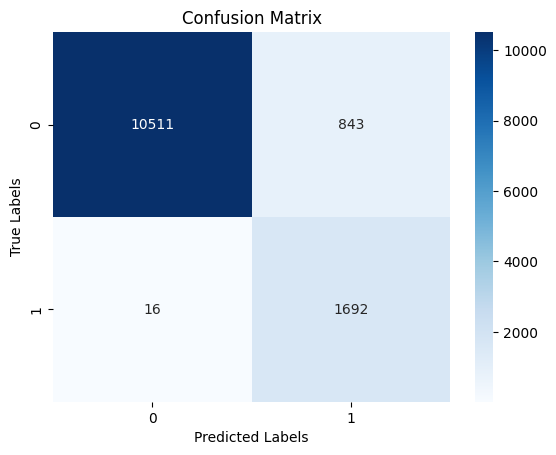

Accuracy :93.42367171949165%
Epoch 30/150, Loss: 0.686752438545227


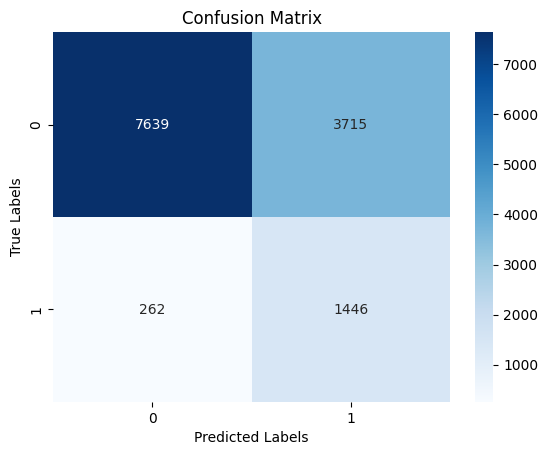

Accuracy :69.55290154647068%
Epoch 31/150, Loss: 0.6937642097473145


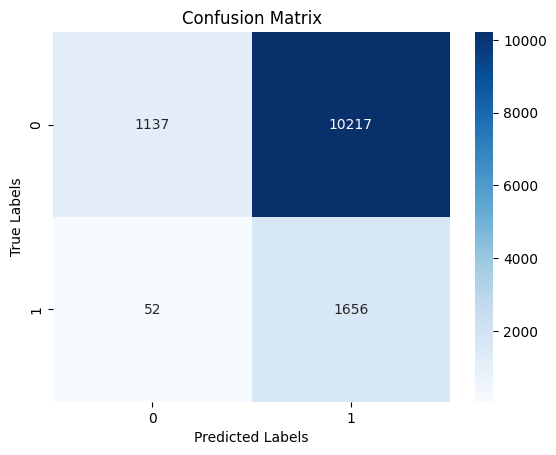

Accuracy :21.382636655948552%
Epoch 32/150, Loss: 0.693264365196228


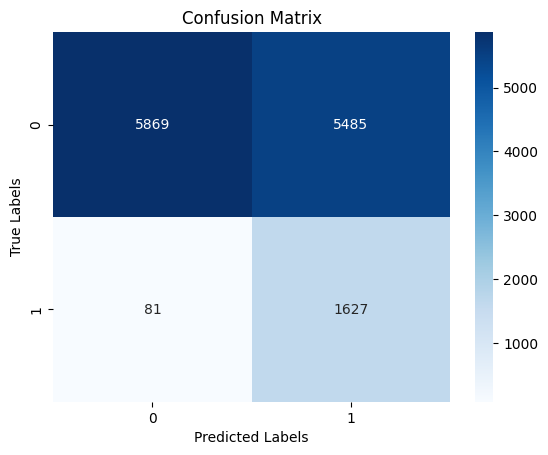

Accuracy :57.387842596845815%
Epoch 33/150, Loss: 0.6929267644882202


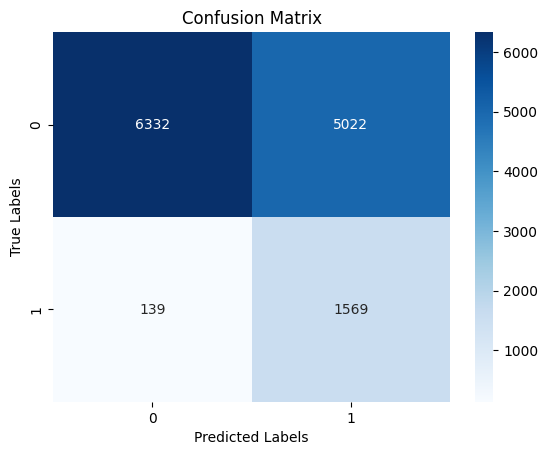

Accuracy :60.48843974888991%
Epoch 34/150, Loss: 0.6891355514526367


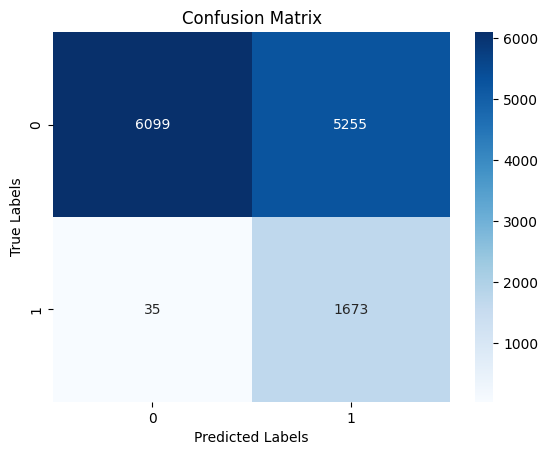

Accuracy :59.50084213749809%
Epoch 35/150, Loss: 0.6898924112319946


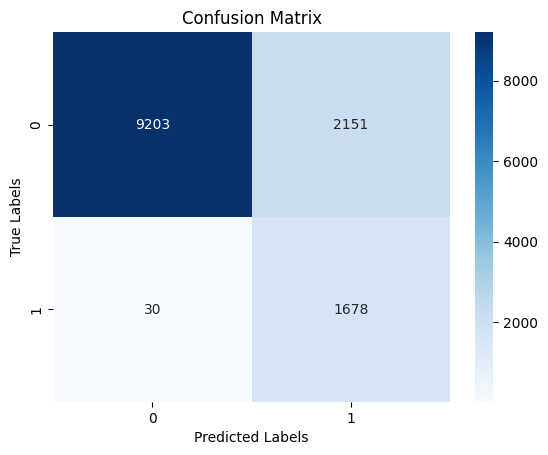

Accuracy :83.30271015158475%
Epoch 36/150, Loss: 0.6881126165390015


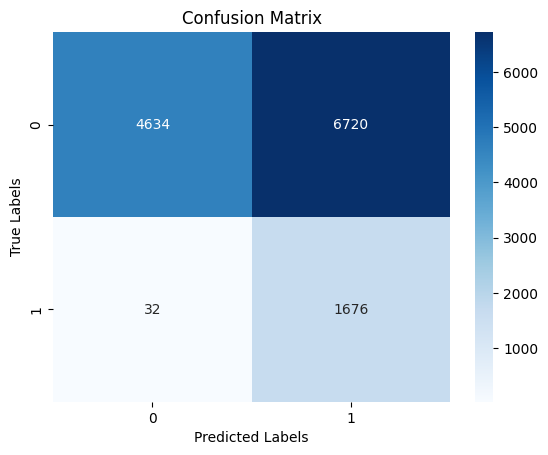

Accuracy :48.308069208390755%
Epoch 37/150, Loss: 0.6901174783706665


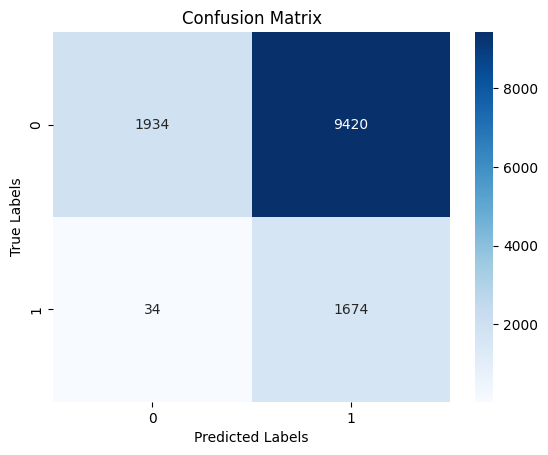

Accuracy :27.62210993722248%
Epoch 38/150, Loss: 0.6904770731925964


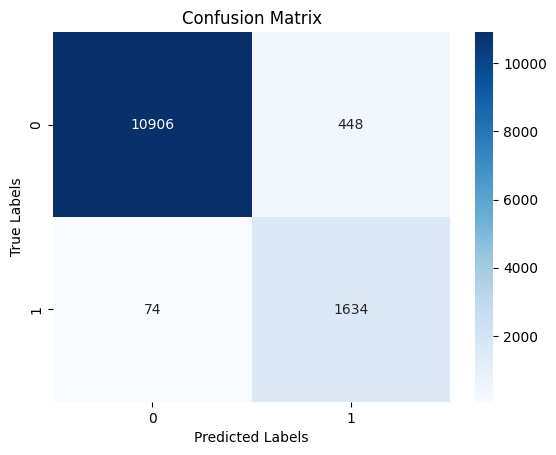

Accuracy :96.00367478180983%
Epoch 39/150, Loss: 0.6893171072006226


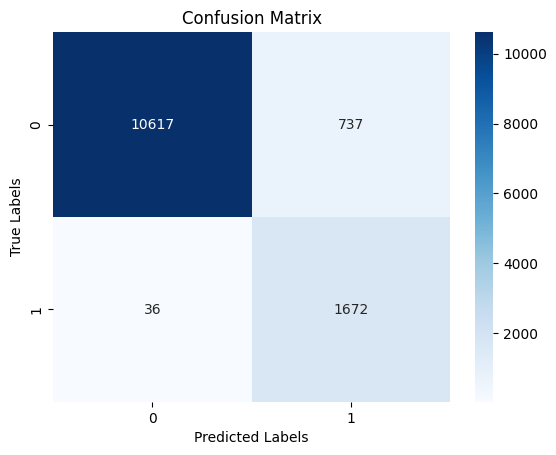

Accuracy :94.0820701270862%
Epoch 40/150, Loss: 0.6858845949172974


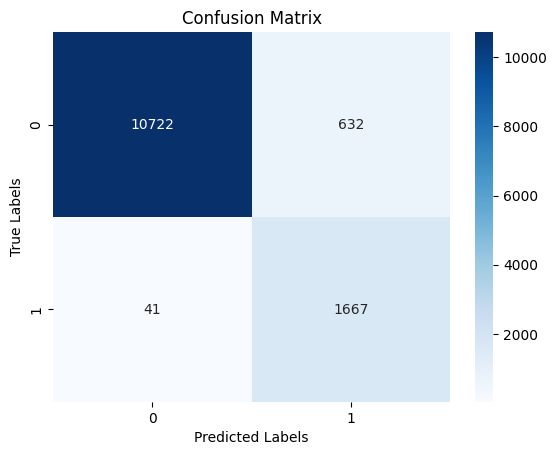

Accuracy :94.84764967080079%
Epoch 41/150, Loss: 0.6898102760314941


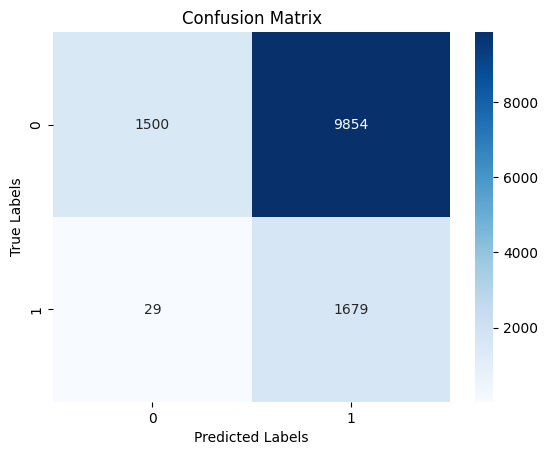

Accuracy :24.337773694686877%
Epoch 42/150, Loss: 0.6897642612457275


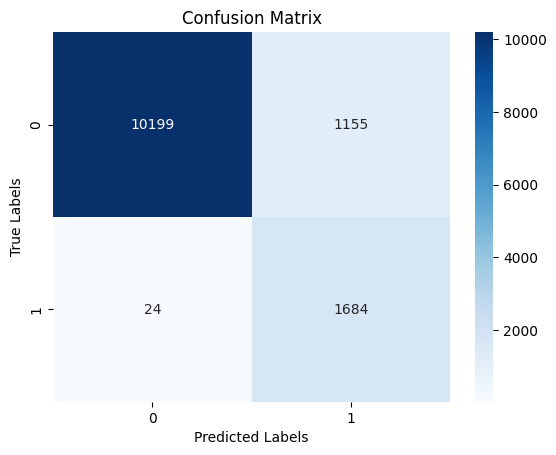

Accuracy :90.97381717960496%
Epoch 43/150, Loss: 0.6930016279220581


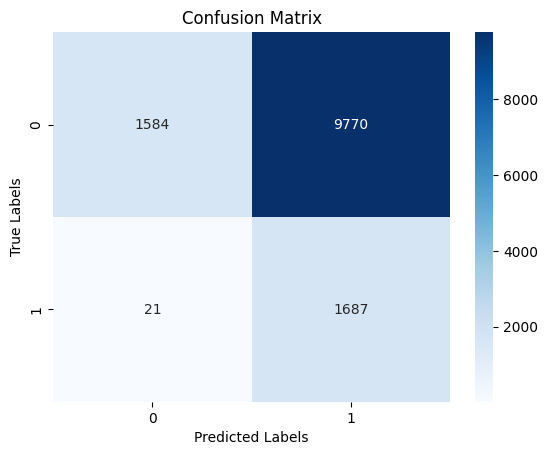

Accuracy :25.042106874904302%
Epoch 44/150, Loss: 0.6889681220054626


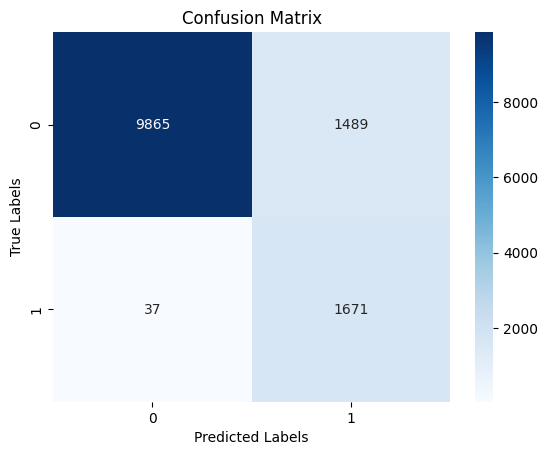

Accuracy :88.31725616291533%
Epoch 45/150, Loss: 0.6850006580352783


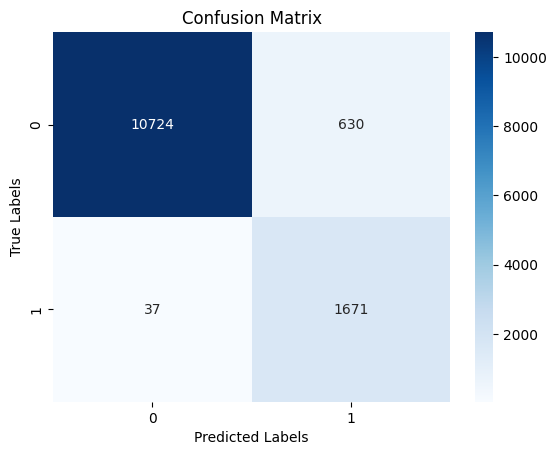

Accuracy :94.89358444342368%
Epoch 46/150, Loss: 0.690383791923523


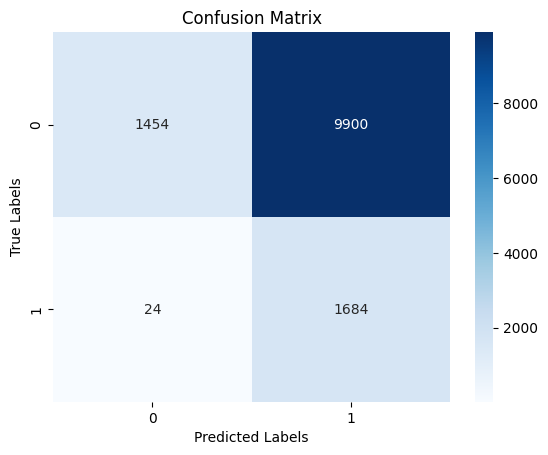

Accuracy :24.023886081763894%
Epoch 47/150, Loss: 0.6852847337722778


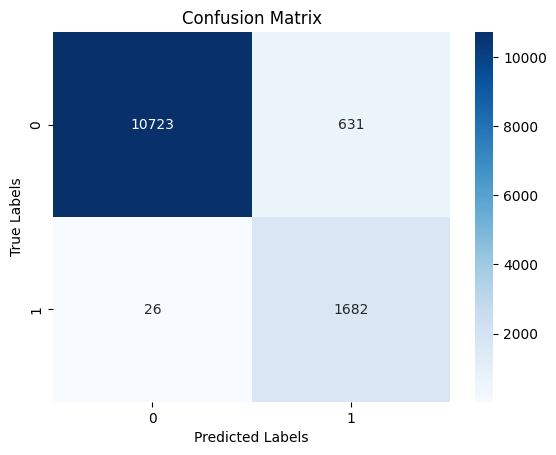

Accuracy :94.97014239779513%
Epoch 48/150, Loss: 0.6929224729537964


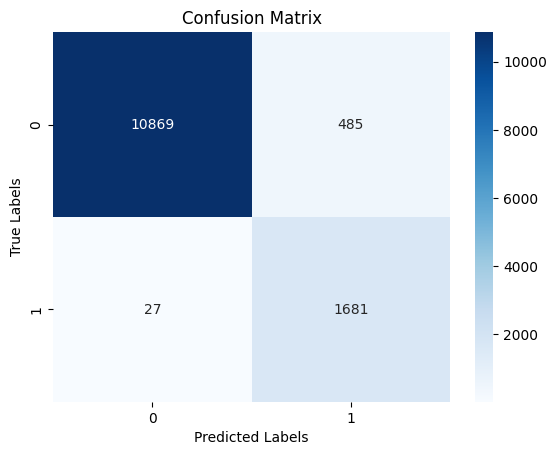

Accuracy :96.08023273618129%
Epoch 49/150, Loss: 0.6892241835594177


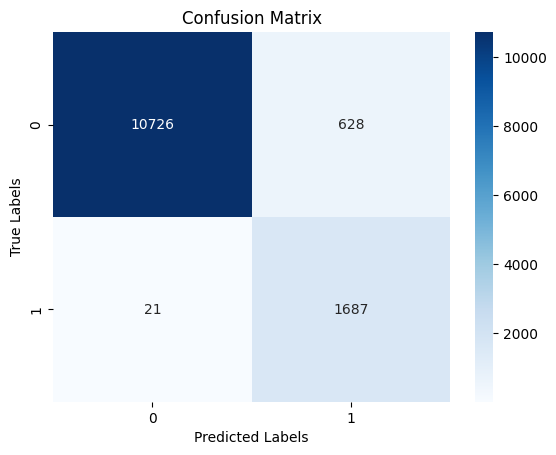

Accuracy :95.0313887612923%
Epoch 50/150, Loss: 0.6923436522483826


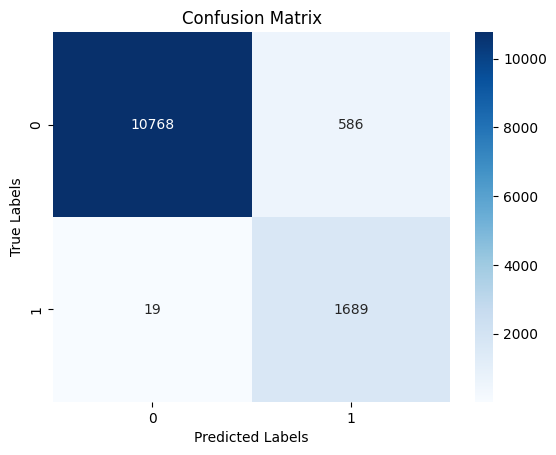

Accuracy :95.36824376052671%
Epoch 51/150, Loss: 0.6811926364898682


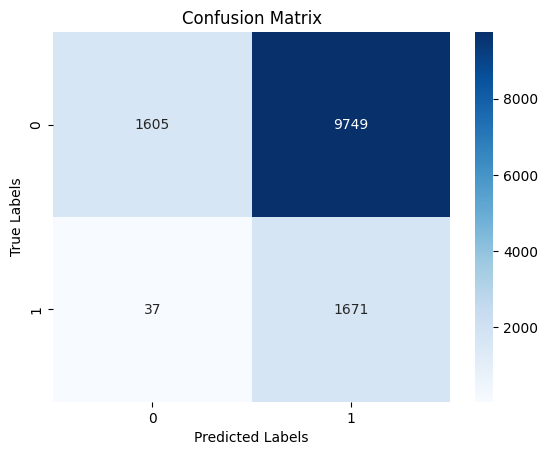

Accuracy :25.080385852090032%
Epoch 52/150, Loss: 0.6890951991081238


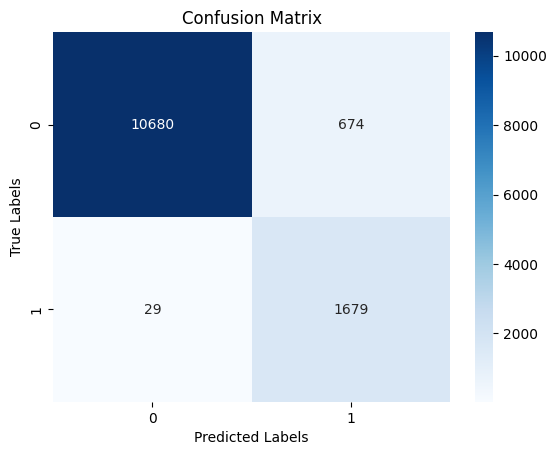

Accuracy :94.61797580768642%
Epoch 53/150, Loss: 0.6865876913070679


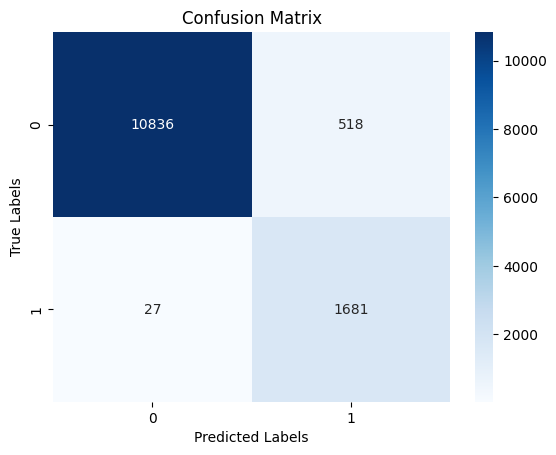

Accuracy :95.82759148675547%
Epoch 54/150, Loss: 0.690068244934082


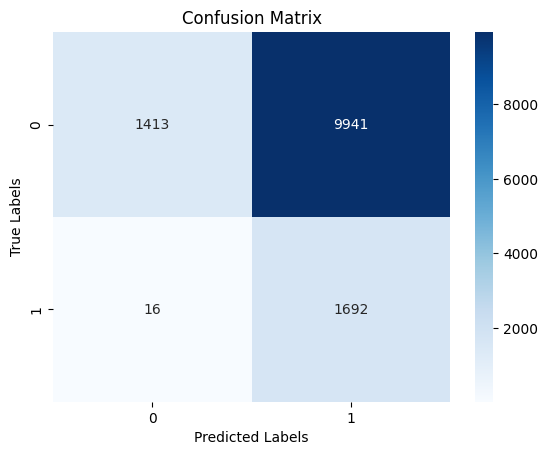

Accuracy :23.771244832338077%
Epoch 55/150, Loss: 0.6907496452331543


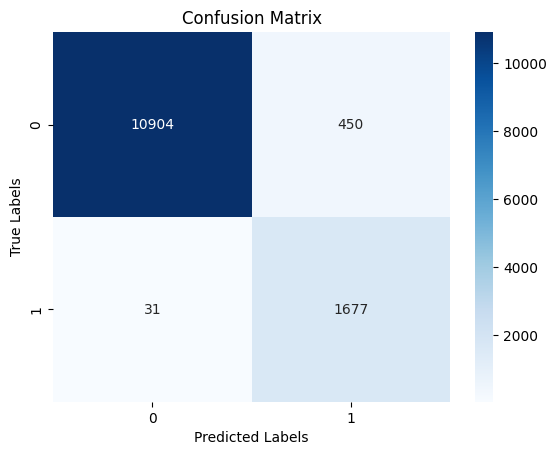

Accuracy :96.31756239473282%
Epoch 56/150, Loss: 0.6887091994285583


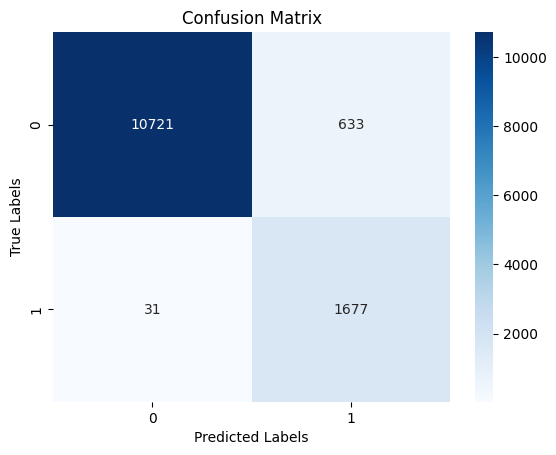

Accuracy :94.91655182973511%
Epoch 57/150, Loss: 0.686168372631073


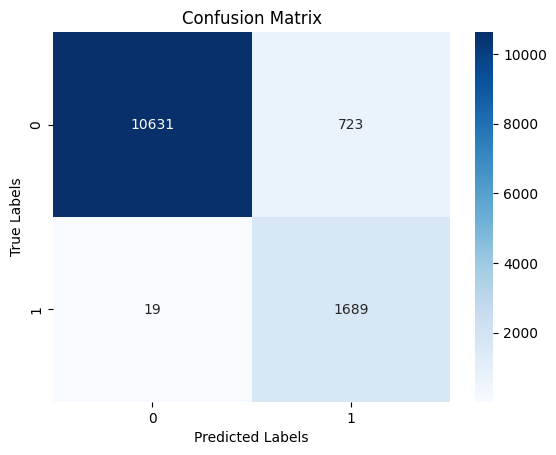

Accuracy :94.31939978563773%
Epoch 58/150, Loss: 0.6806485056877136


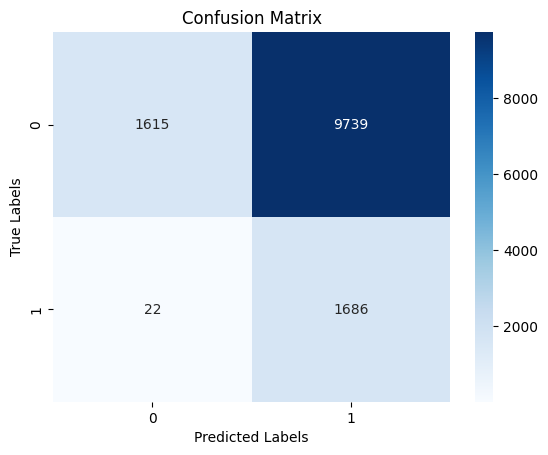

Accuracy :25.271780738018677%
Epoch 59/150, Loss: 0.685912013053894


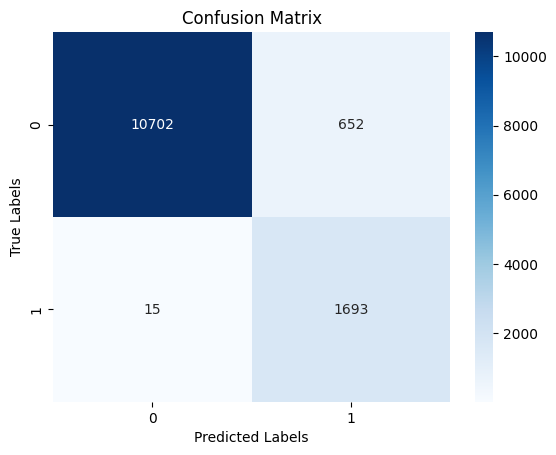

Accuracy :94.89358444342368%
Epoch 60/150, Loss: 0.689213752746582


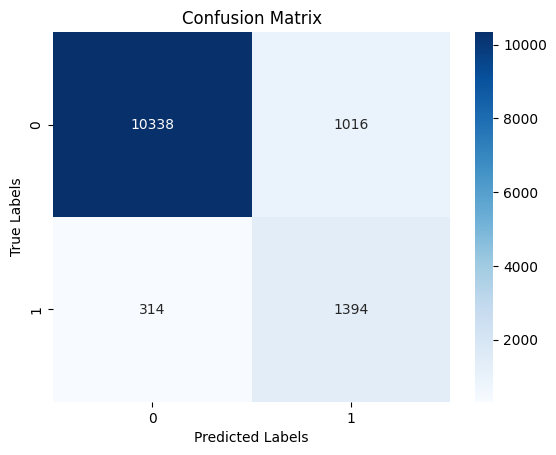

Accuracy :89.81779206859592%
Epoch 61/150, Loss: 0.6889681220054626


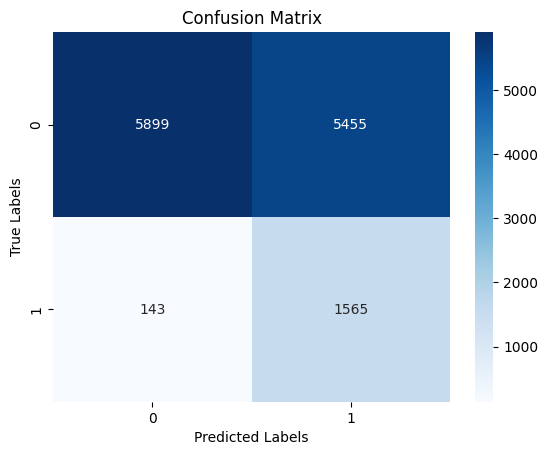

Accuracy :57.14285714285714%
Epoch 62/150, Loss: 0.6936432719230652


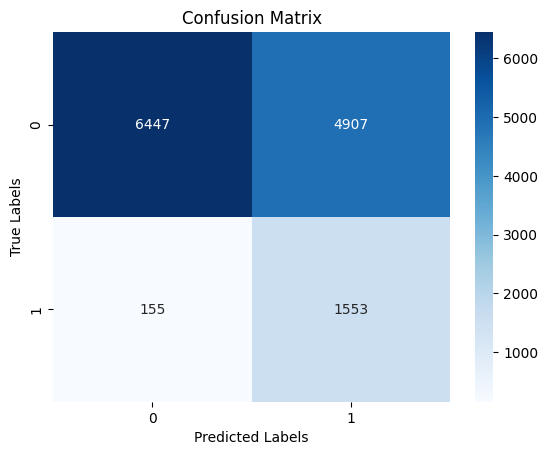

Accuracy :61.24636349716736%
Epoch 63/150, Loss: 0.6894888877868652


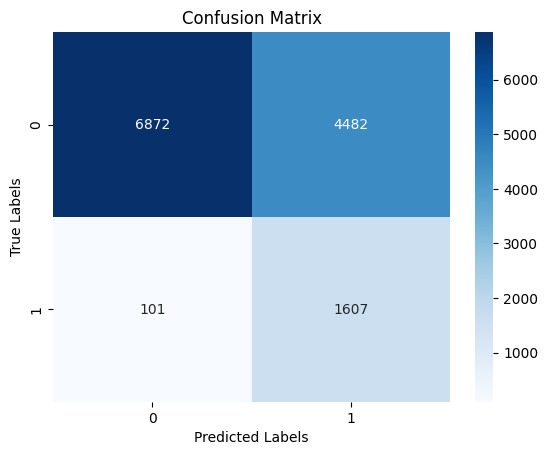

Accuracy :64.91348951156026%
Epoch 64/150, Loss: 0.6821165084838867


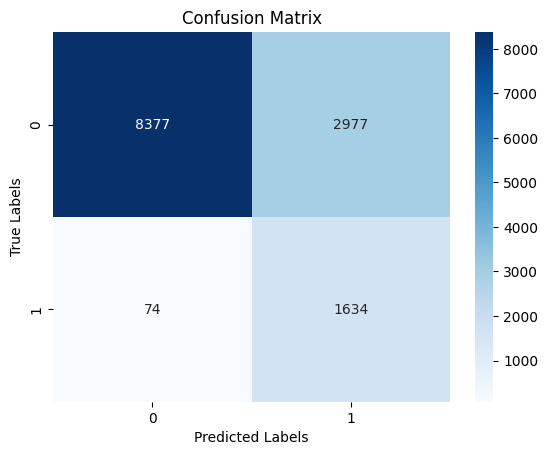

Accuracy :76.6421681212678%
Epoch 65/150, Loss: 0.6851625442504883


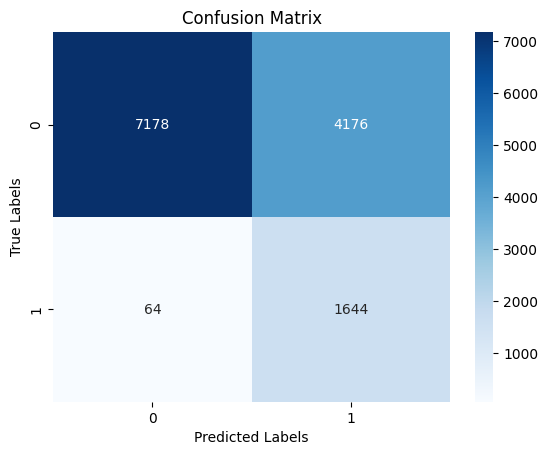

Accuracy :67.5394273465013%
Epoch 66/150, Loss: 0.6929585337638855


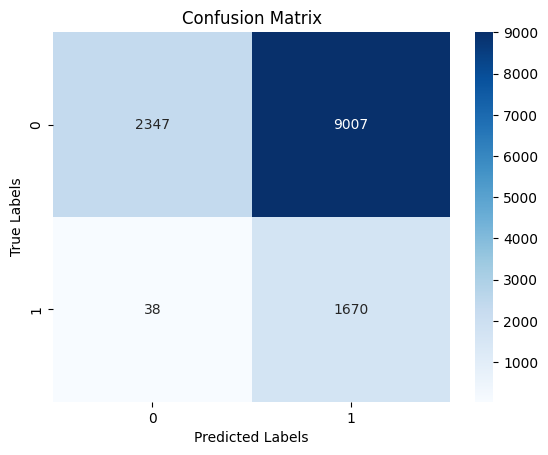

Accuracy :30.753330271015155%
Epoch 67/150, Loss: 0.6819438934326172


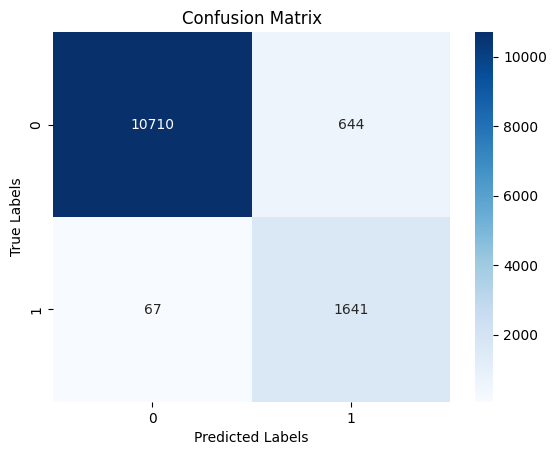

Accuracy :94.55672944418924%
Epoch 68/150, Loss: 0.6904935836791992


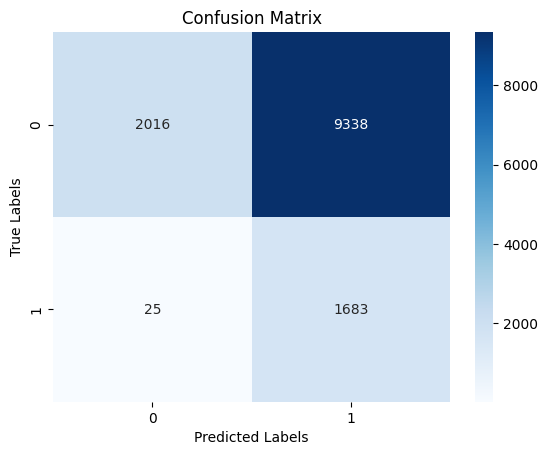

Accuracy :28.31878732200276%
Epoch 69/150, Loss: 0.6871880292892456


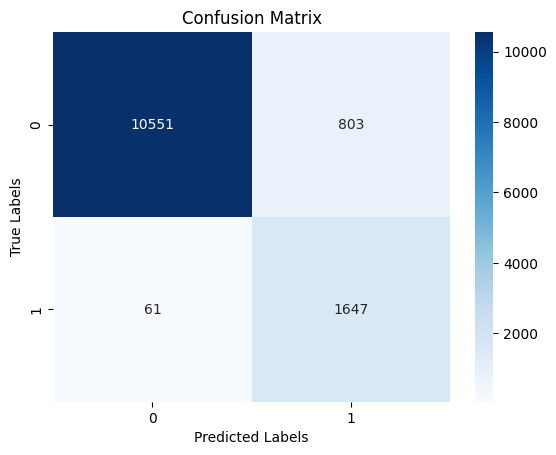

Accuracy :93.38539274230592%
Epoch 70/150, Loss: 0.6728543043136597


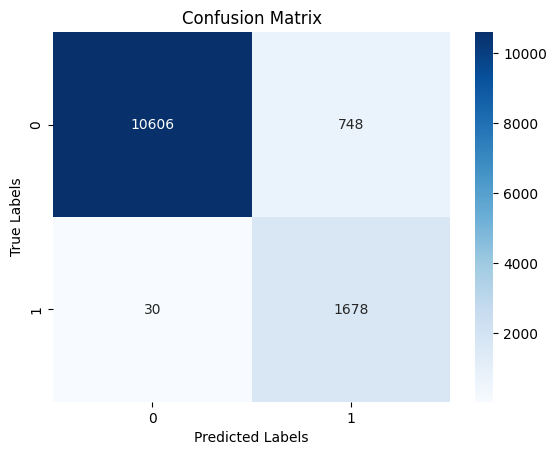

Accuracy :94.04379114990049%
Epoch 71/150, Loss: 0.6867796778678894


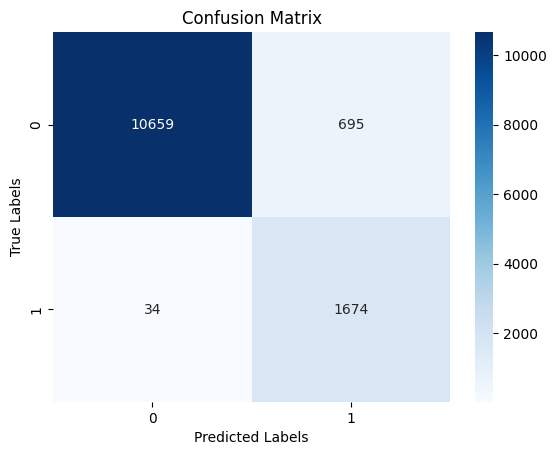

Accuracy :94.41892512632063%
Epoch 72/150, Loss: 0.6791753172874451


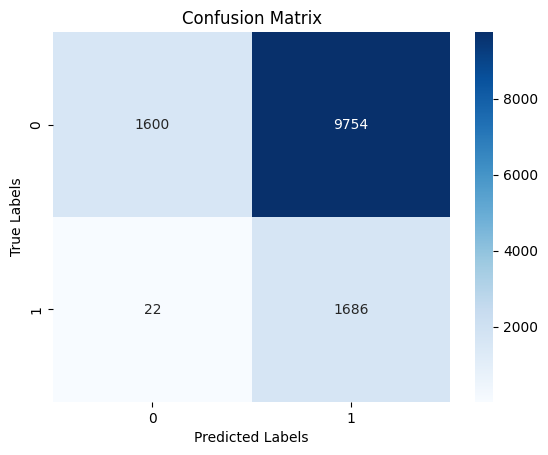

Accuracy :25.15694380646149%
Epoch 73/150, Loss: 0.6889634132385254


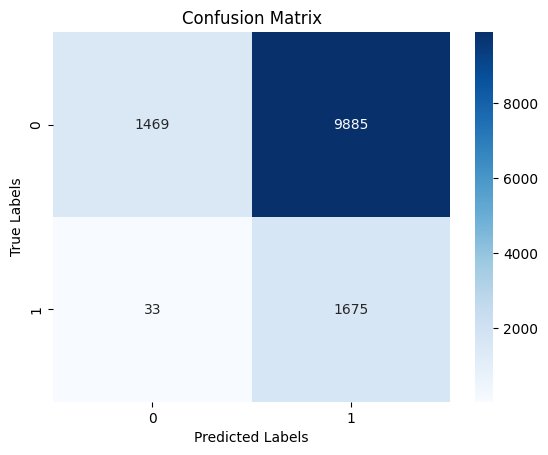

Accuracy :24.06982085438677%
Epoch 74/150, Loss: 0.6904661059379578


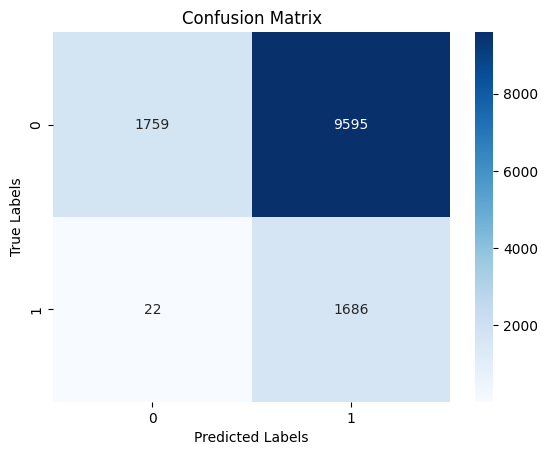

Accuracy :26.374215280967693%
Epoch 75/150, Loss: 0.6929453611373901


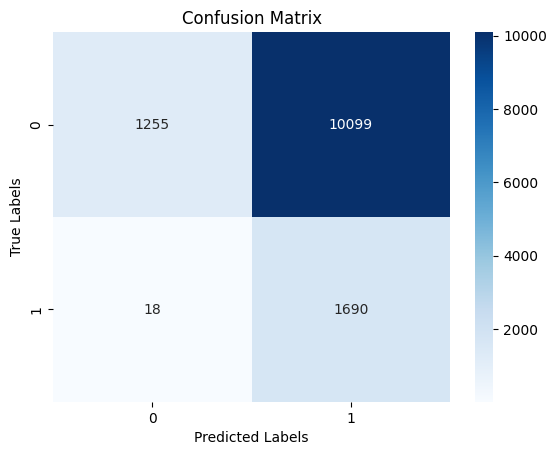

Accuracy :22.546317562394734%
Epoch 76/150, Loss: 0.690021276473999


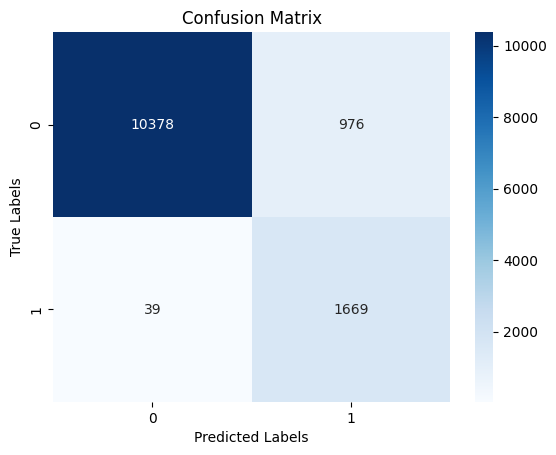

Accuracy :92.22936763129688%
Epoch 77/150, Loss: 0.6929479837417603


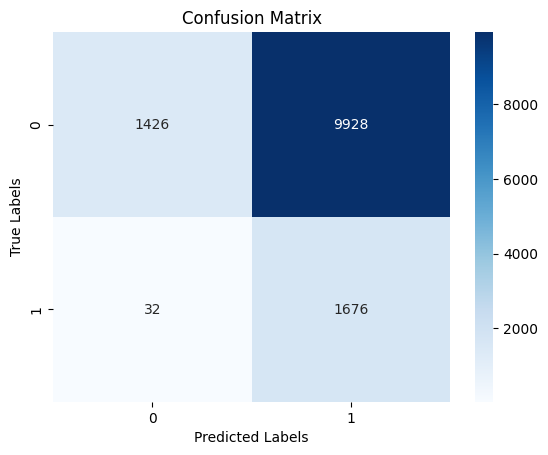

Accuracy :23.74827744602664%
Epoch 78/150, Loss: 0.689889132976532


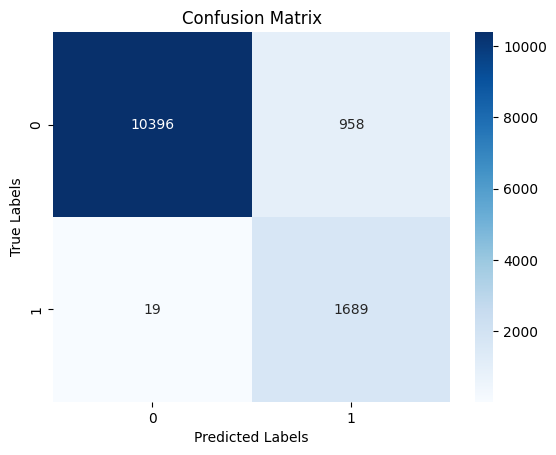

Accuracy :92.52028785790843%
Epoch 79/150, Loss: 0.6810778379440308


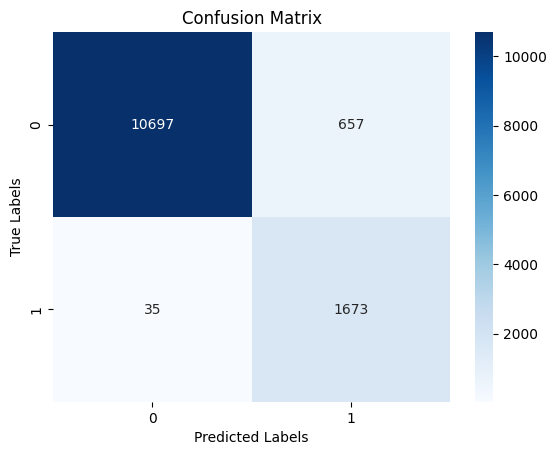

Accuracy :94.70218955749502%
Epoch 80/150, Loss: 0.6930772662162781


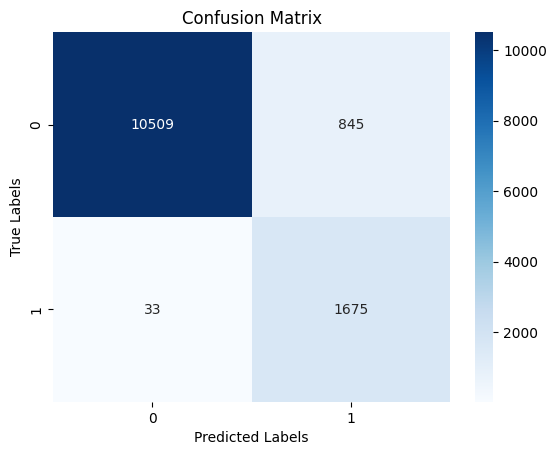

Accuracy :93.27821160618588%
Epoch 81/150, Loss: 0.6930769681930542


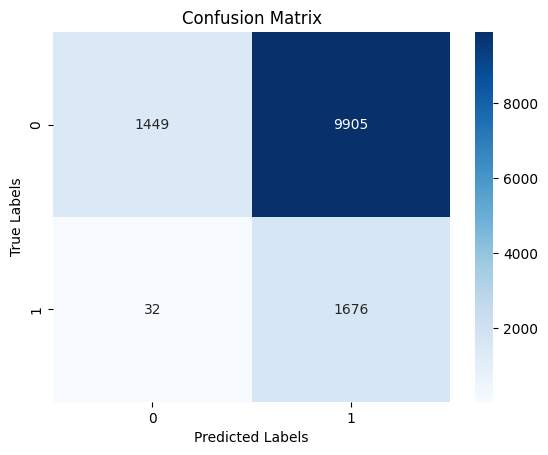

Accuracy :23.924360741081%
Epoch 82/150, Loss: 0.6867502927780151


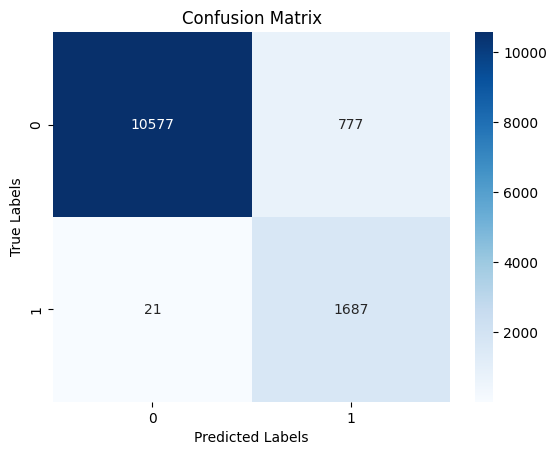

Accuracy :93.89067524115757%
Epoch 83/150, Loss: 0.6927410960197449


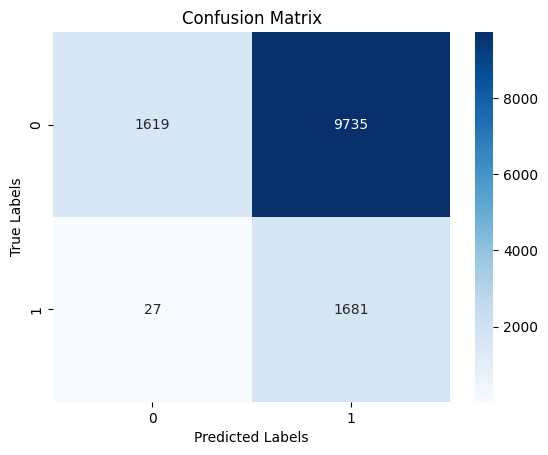

Accuracy :25.264124942581535%
Epoch 84/150, Loss: 0.6811779737472534


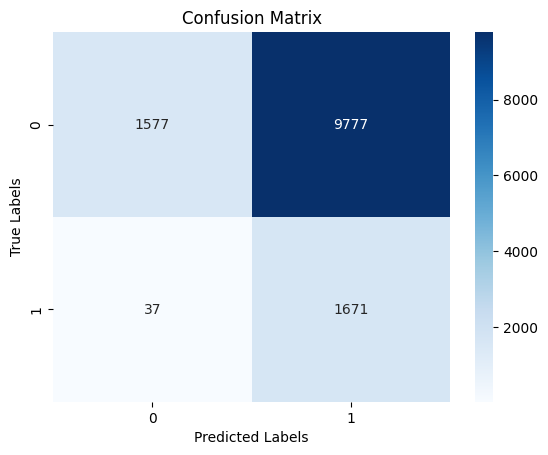

Accuracy :24.866023579849948%
Epoch 85/150, Loss: 0.6929969191551208


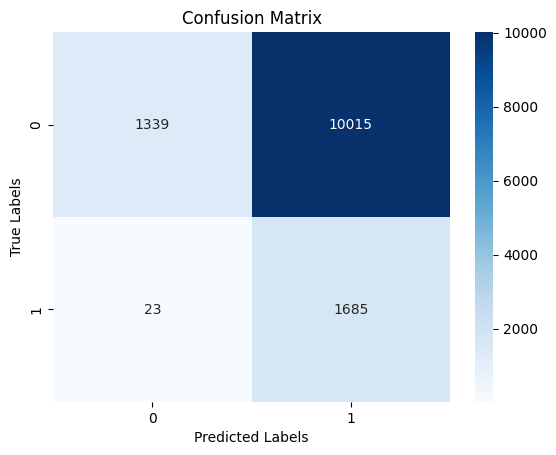

Accuracy :23.15112540192926%
Epoch 86/150, Loss: 0.6891970634460449


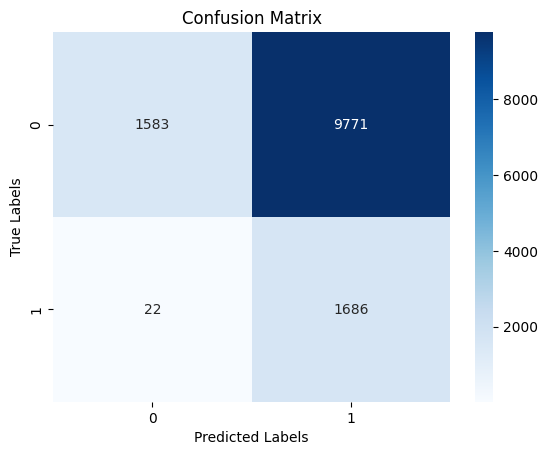

Accuracy :25.026795284030012%
Epoch 87/150, Loss: 0.6862819194793701


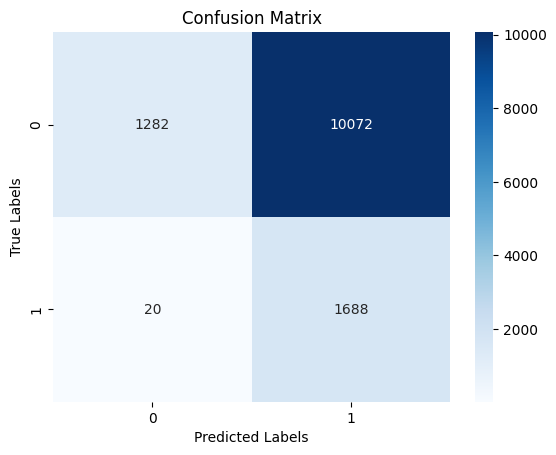

Accuracy :22.73771244832338%
Epoch 88/150, Loss: 0.6873933672904968


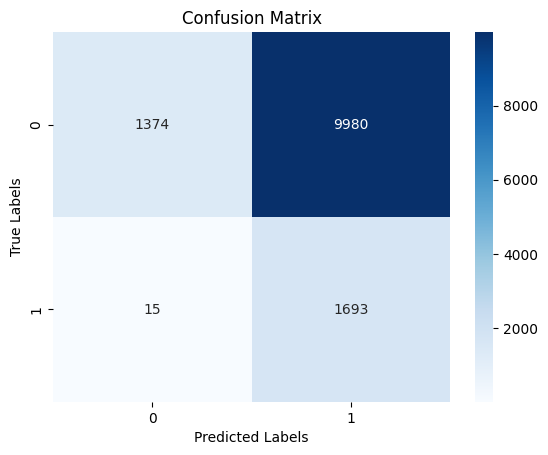

Accuracy :23.480324605726537%
Epoch 89/150, Loss: 0.6863530874252319


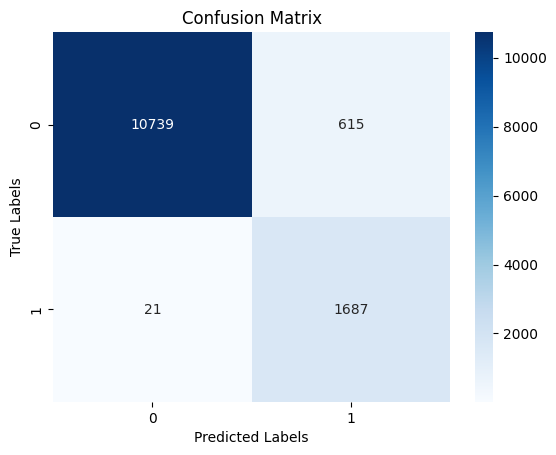

Accuracy :95.1309141019752%
Epoch 90/150, Loss: 0.685248851776123


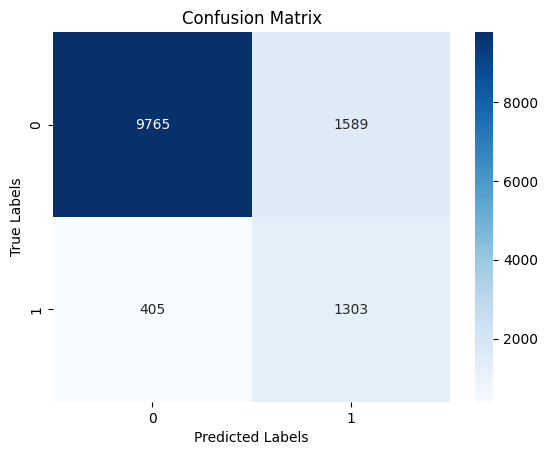

Accuracy :84.73434389833103%
Epoch 91/150, Loss: 0.6937379837036133


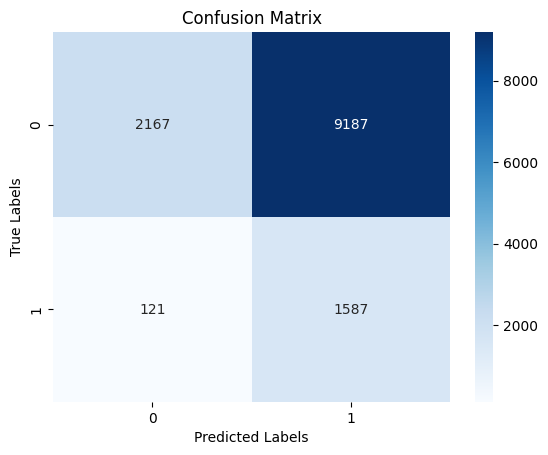

Accuracy :28.739856071045782%
Epoch 92/150, Loss: 0.685579776763916


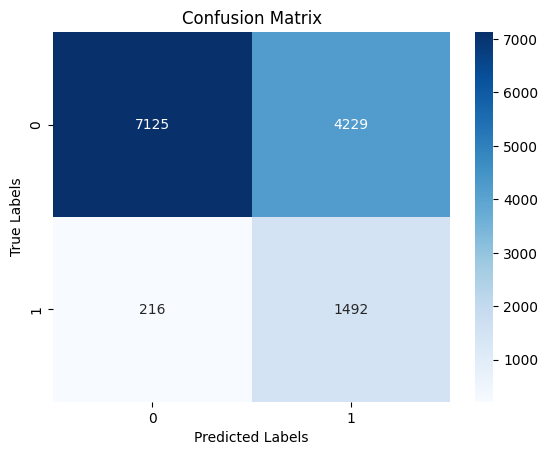

Accuracy :65.96998928188638%
Epoch 93/150, Loss: 0.6908559203147888


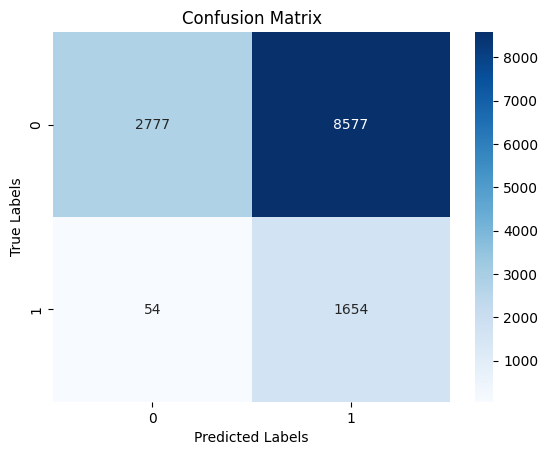

Accuracy :33.92282958199357%
Epoch 94/150, Loss: 0.6881195902824402


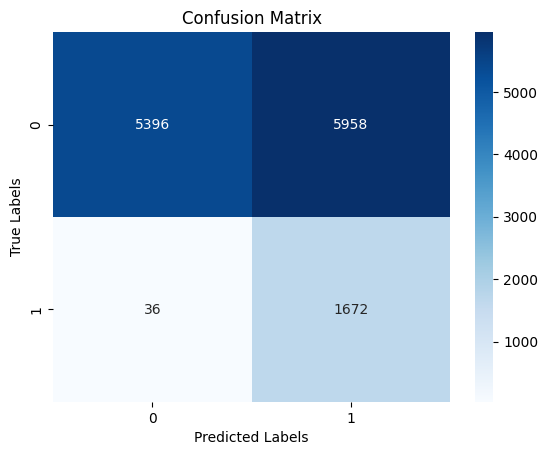

Accuracy :54.11116214974736%
Epoch 95/150, Loss: 0.6890069842338562


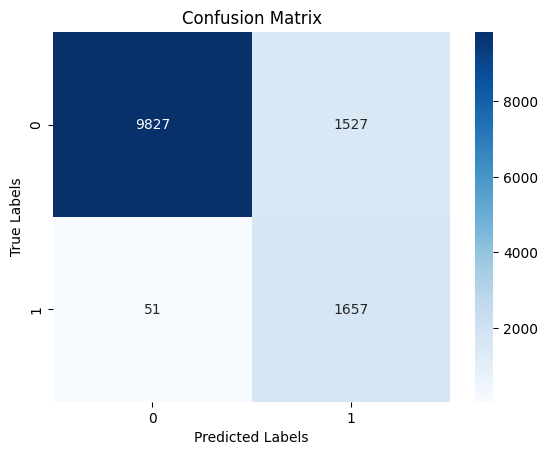

Accuracy :87.91915480018375%
Epoch 96/150, Loss: 0.6871969103813171


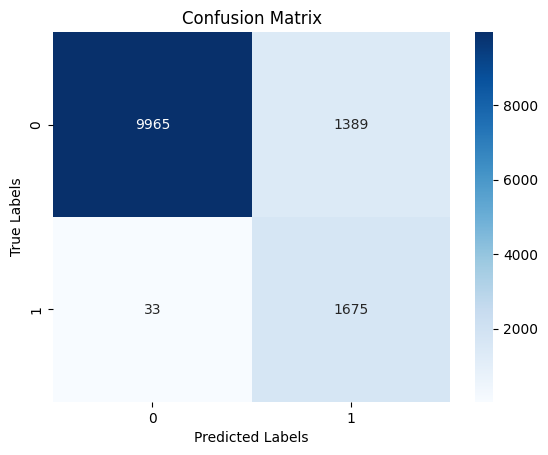

Accuracy :89.1134588883785%
Epoch 97/150, Loss: 0.6867513060569763


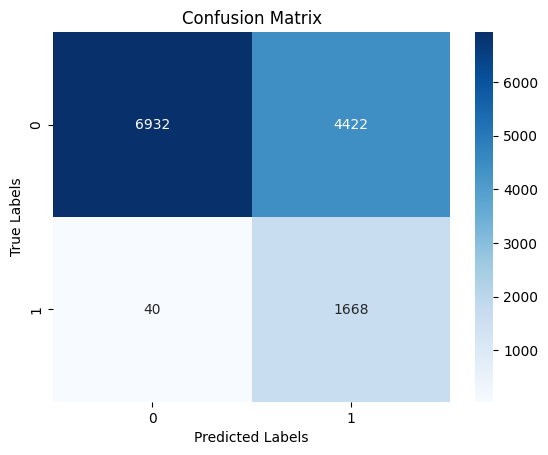

Accuracy :65.8398407594549%
Epoch 98/150, Loss: 0.683074414730072


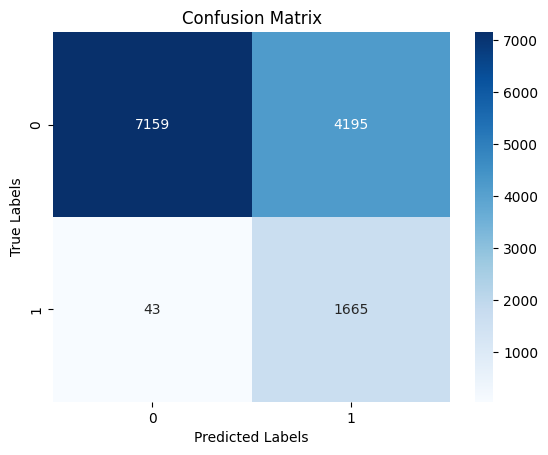

Accuracy :67.55473893737559%
Epoch 99/150, Loss: 0.6891963481903076


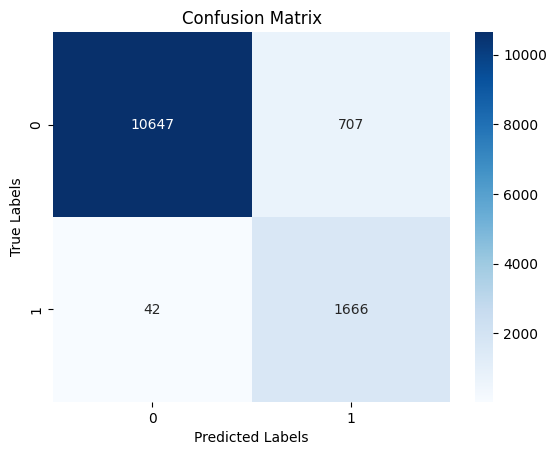

Accuracy :94.26580921757771%
Epoch 100/150, Loss: 0.6860525012016296


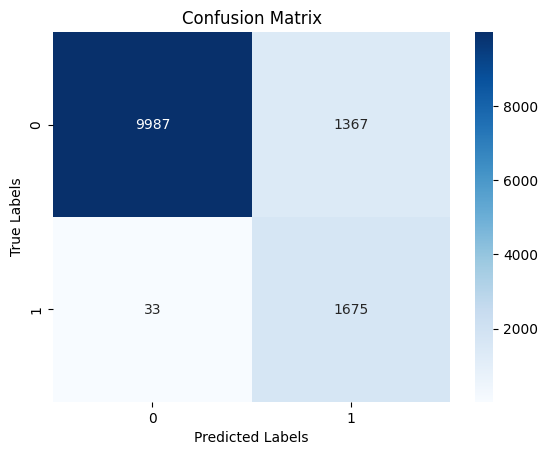

Accuracy :89.28188638799571%
Epoch 101/150, Loss: 0.6897826194763184


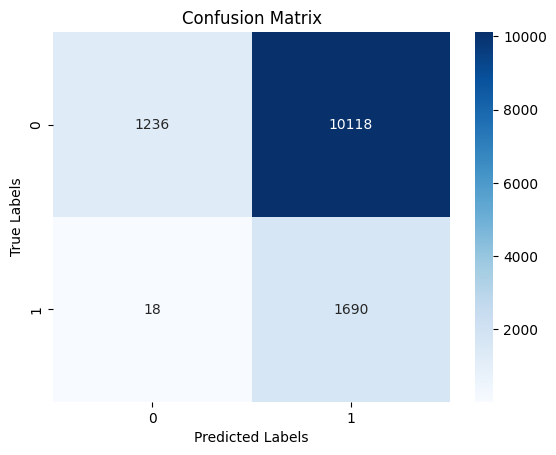

Accuracy :22.40085744908896%
Epoch 102/150, Loss: 0.6830881834030151


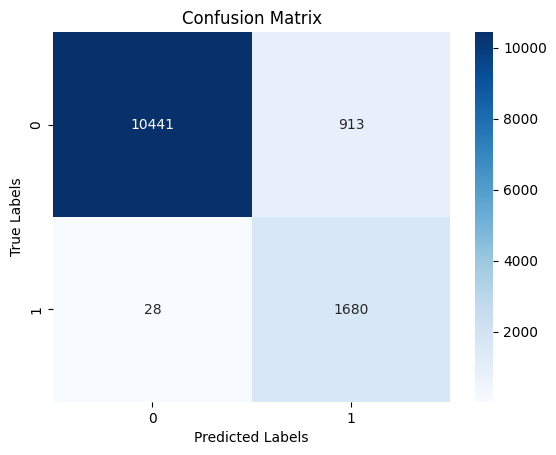

Accuracy :92.79589649364569%
Epoch 103/150, Loss: 0.6858104467391968


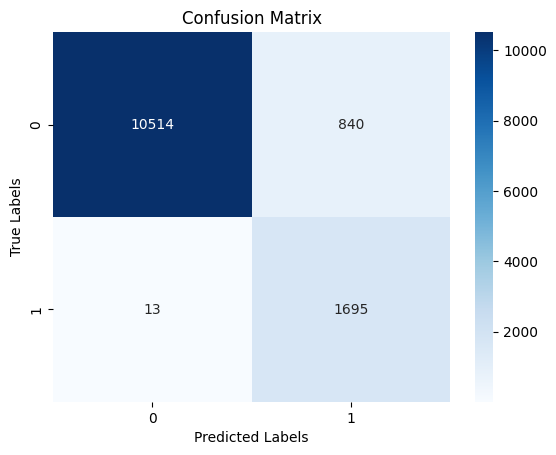

Accuracy :93.46960649211454%
Epoch 104/150, Loss: 0.686120867729187


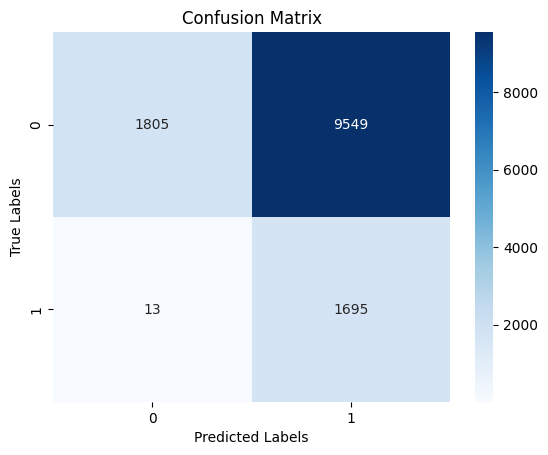

Accuracy :26.79528403001072%
Epoch 105/150, Loss: 0.6913074254989624


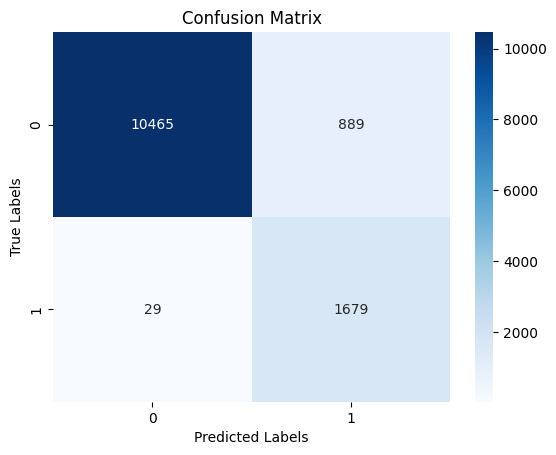

Accuracy :92.97197978870004%
Epoch 106/150, Loss: 0.6840721964836121


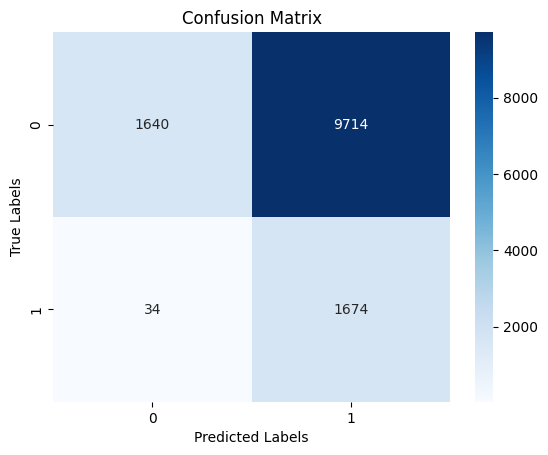

Accuracy :25.37130607870158%
Epoch 107/150, Loss: 0.6900362968444824


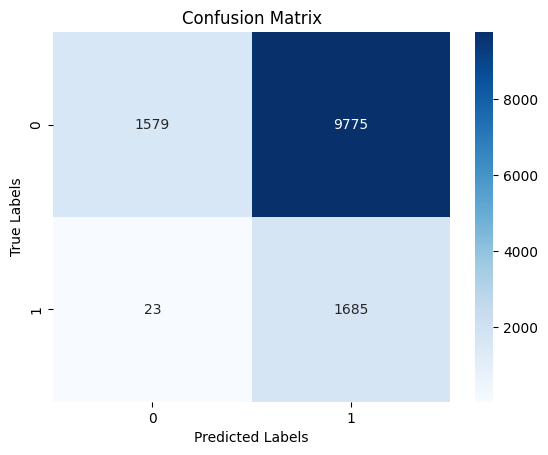

Accuracy :24.98851630684428%
Epoch 108/150, Loss: 0.6841549873352051


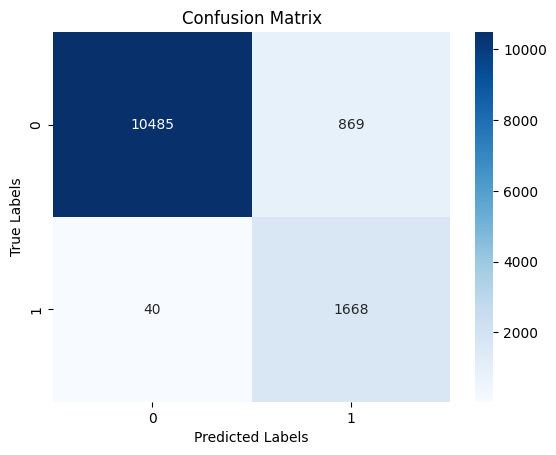

Accuracy :93.04088194763436%
Epoch 109/150, Loss: 0.683158278465271


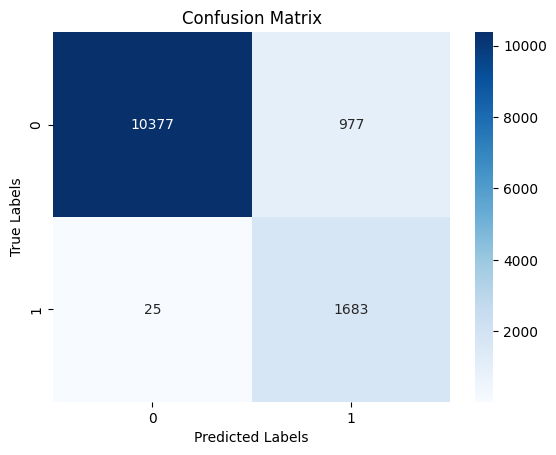

Accuracy :92.3288929719798%
Epoch 110/150, Loss: 0.6930389404296875


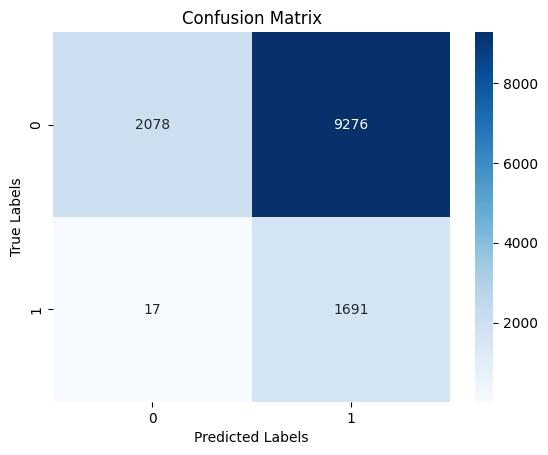

Accuracy :28.85469300260297%
Epoch 111/150, Loss: 0.6890923380851746


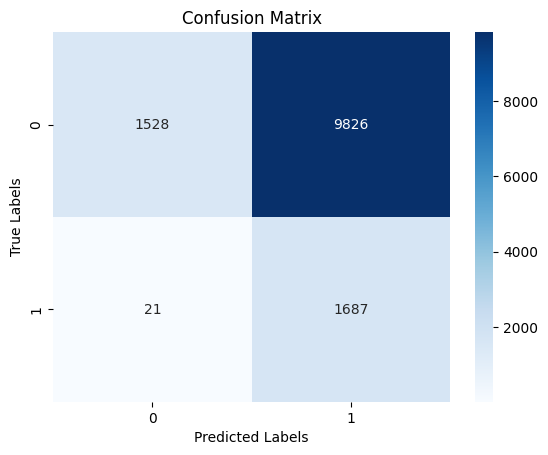

Accuracy :24.61338233042413%
Epoch 112/150, Loss: 0.6898400187492371


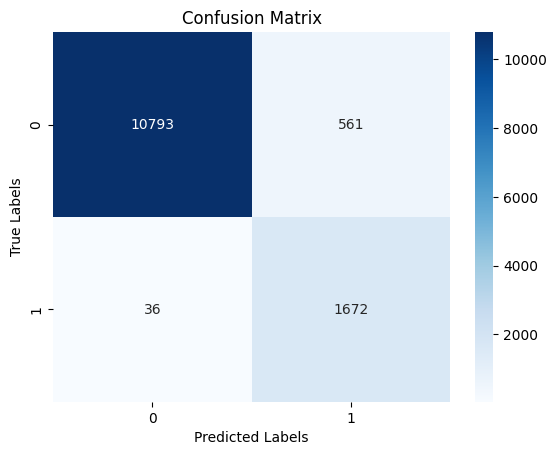

Accuracy :95.42949012402389%
Epoch 113/150, Loss: 0.6791607737541199


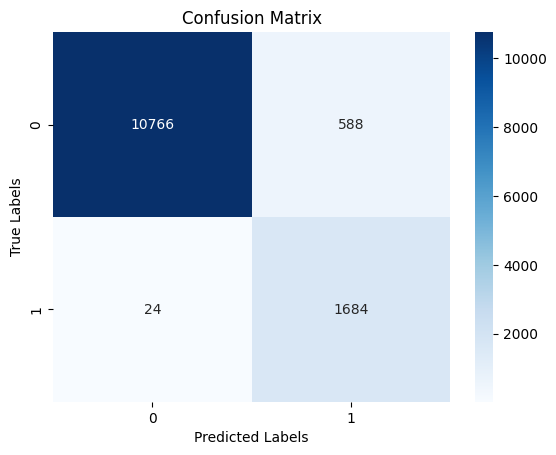

Accuracy :95.3146531924667%
Epoch 114/150, Loss: 0.6904904246330261


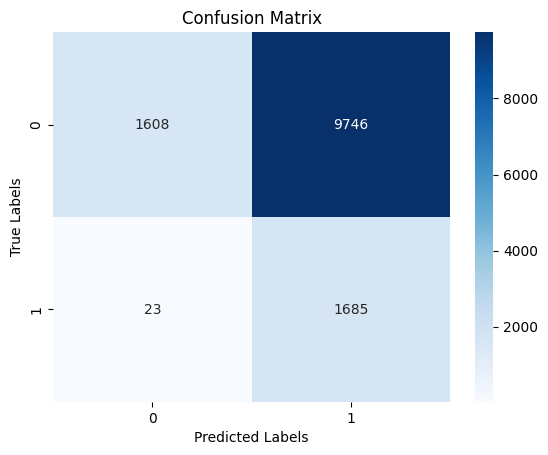

Accuracy :25.210534374521515%
Epoch 115/150, Loss: 0.690565288066864


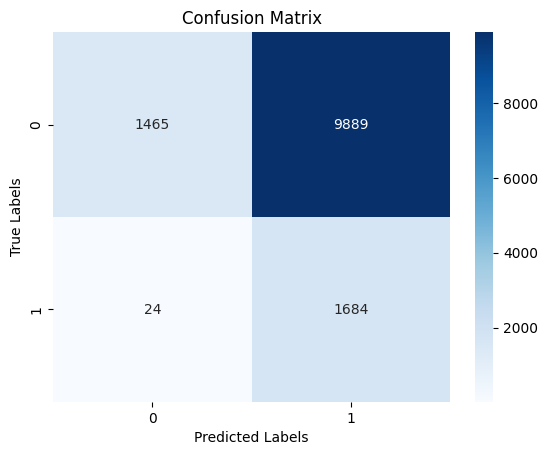

Accuracy :24.1080998315725%
Epoch 116/150, Loss: 0.692034125328064


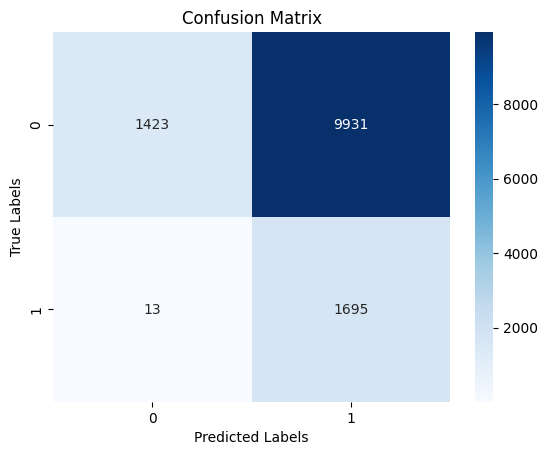

Accuracy :23.87077017302098%
Epoch 117/150, Loss: 0.682726263999939


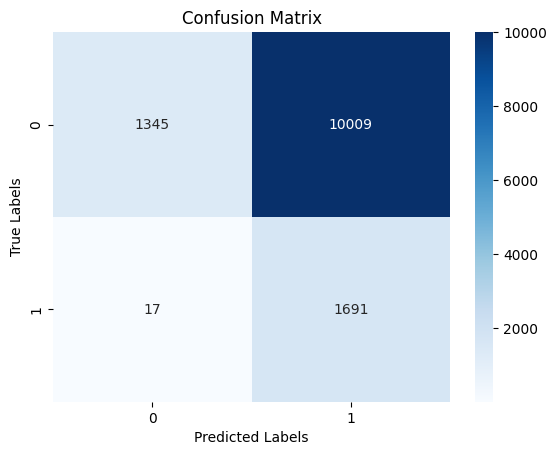

Accuracy :23.24299494717501%
Epoch 118/150, Loss: 0.69073885679245


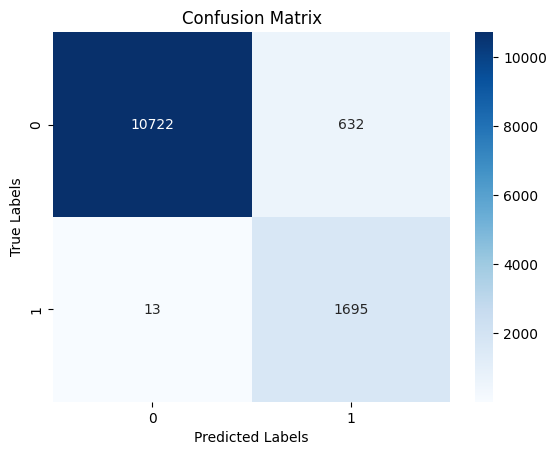

Accuracy :95.06201194304089%
Epoch 119/150, Loss: 0.6926369071006775


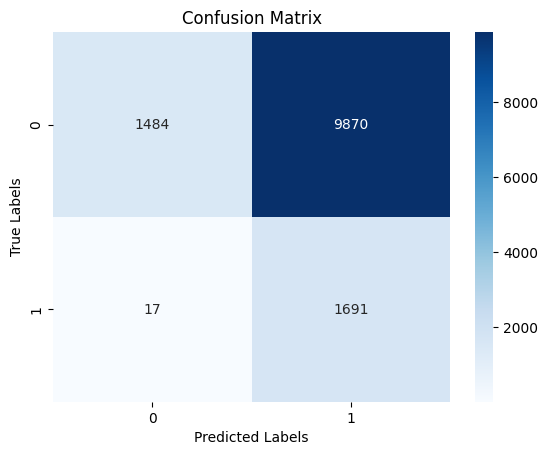

Accuracy :24.307150512938293%
Epoch 120/150, Loss: 0.6900063753128052


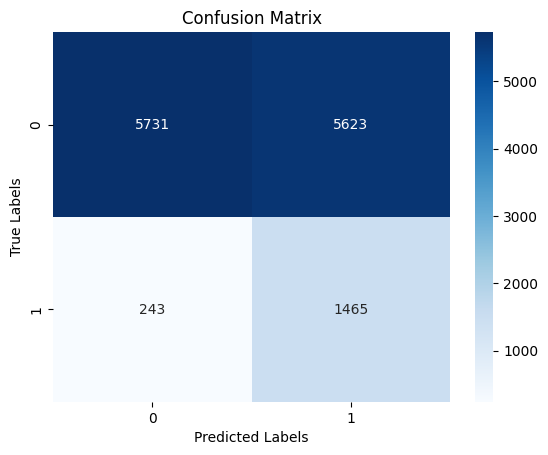

Accuracy :55.09110396570204%
Epoch 121/150, Loss: 0.6916179060935974


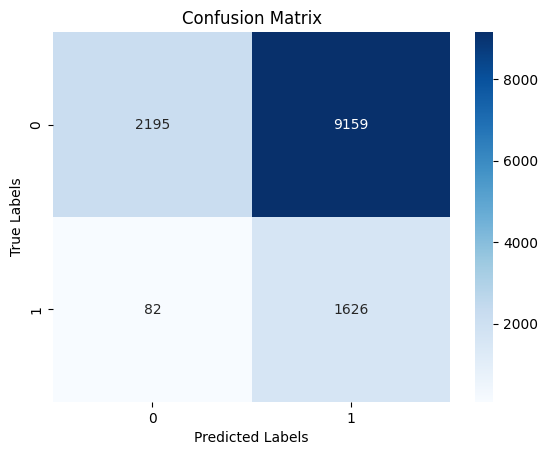

Accuracy :29.252794365334555%
Epoch 122/150, Loss: 0.6872280836105347


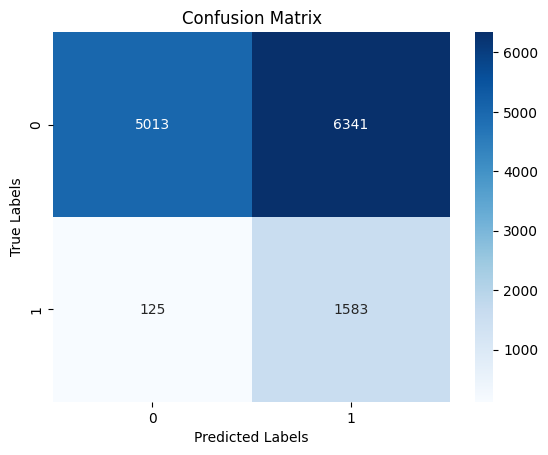

Accuracy :50.49762670341449%
Epoch 123/150, Loss: 0.6926329135894775


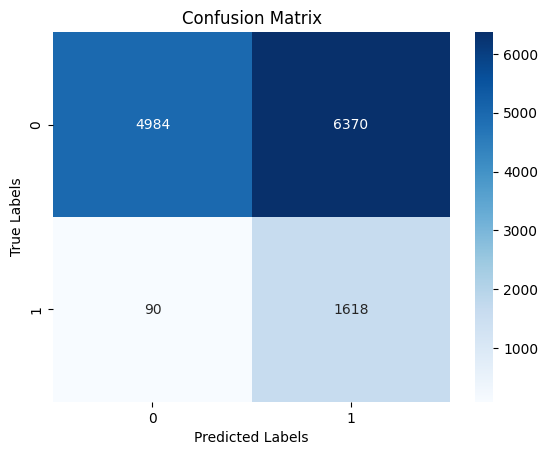

Accuracy :50.543561476037354%
Epoch 124/150, Loss: 0.6851733922958374


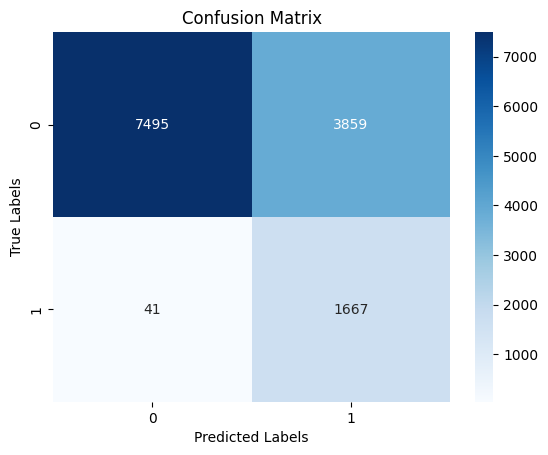

Accuracy :70.14239779513092%
Epoch 125/150, Loss: 0.6890067458152771


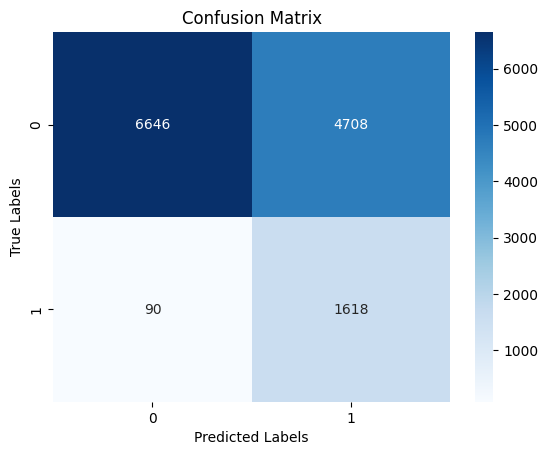

Accuracy :63.26749349257388%
Epoch 126/150, Loss: 0.6829301714897156


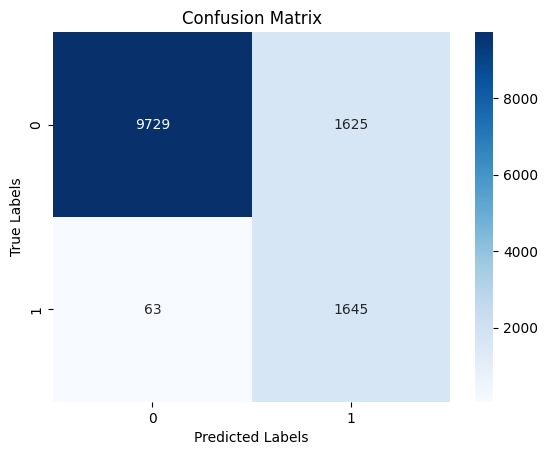

Accuracy :87.07701730209769%
Epoch 127/150, Loss: 0.6900297403335571


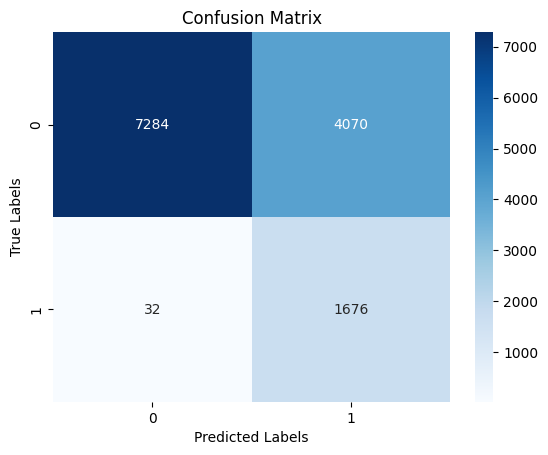

Accuracy :68.59592711682744%
Epoch 128/150, Loss: 0.6828808784484863


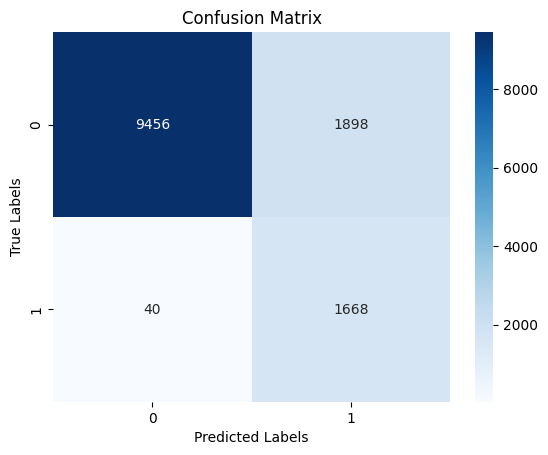

Accuracy :85.16306844281121%
Epoch 129/150, Loss: 0.680679976940155


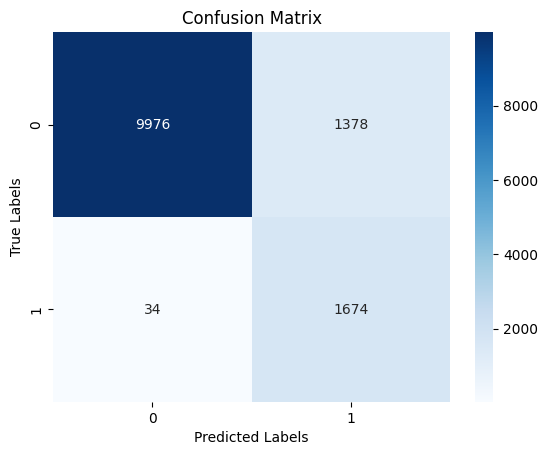

Accuracy :89.19001684274997%
Epoch 130/150, Loss: 0.6890544891357422


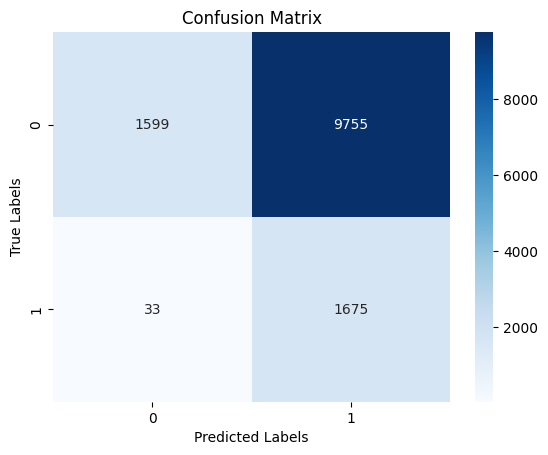

Accuracy :25.06507426121574%
Epoch 131/150, Loss: 0.6932126879692078


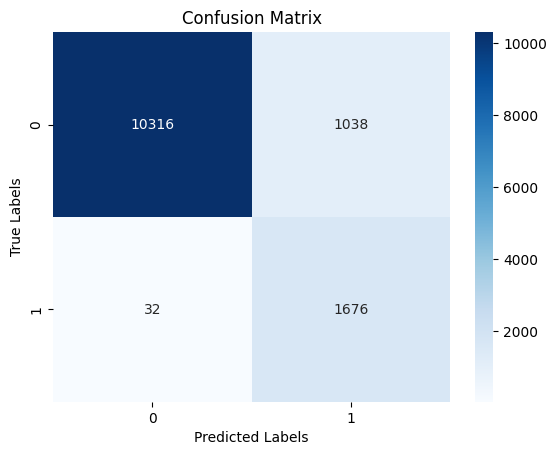

Accuracy :91.80829888225387%
Epoch 132/150, Loss: 0.6907874941825867


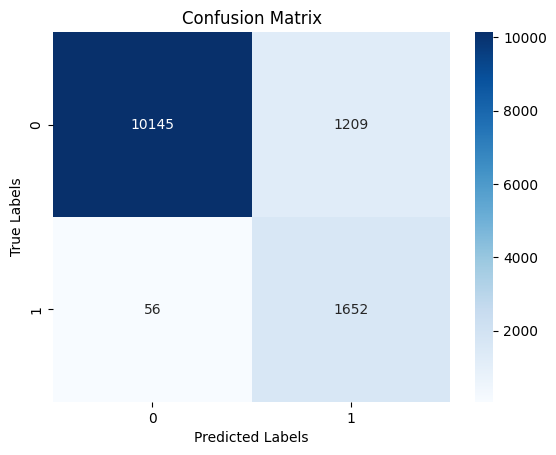

Accuracy :90.31541877201042%
Epoch 133/150, Loss: 0.6848982572555542


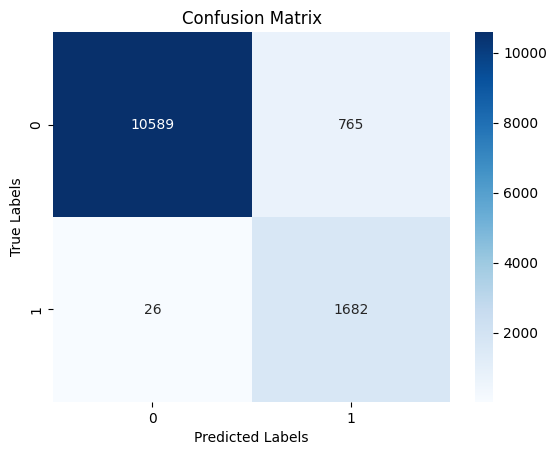

Accuracy :93.94426580921757%
Epoch 134/150, Loss: 0.6927714347839355


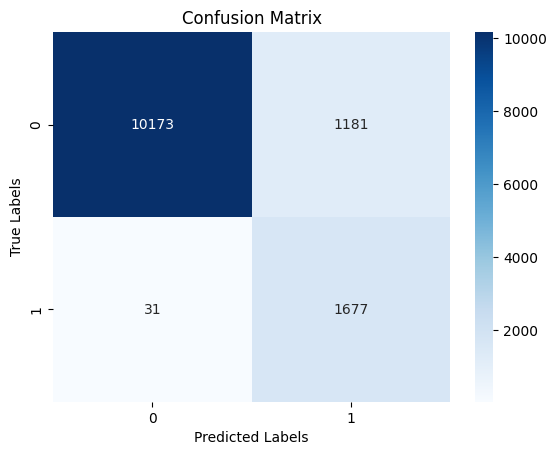

Accuracy :90.72117593017914%
Epoch 135/150, Loss: 0.6893633604049683


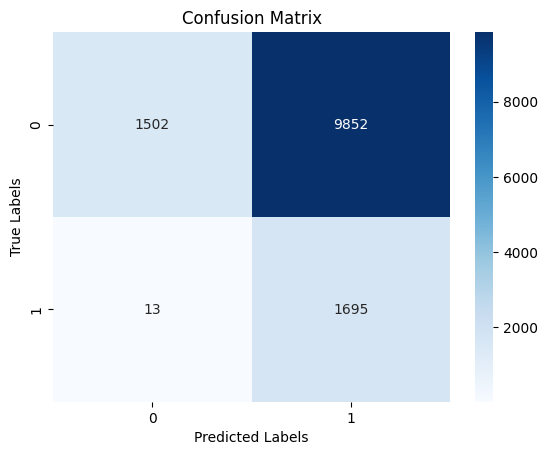

Accuracy :24.475578012555506%
Epoch 136/150, Loss: 0.684262752532959


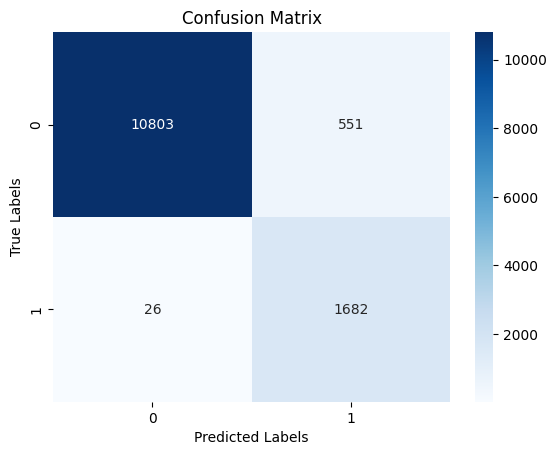

Accuracy :95.5826060327668%
Epoch 137/150, Loss: 0.678257942199707


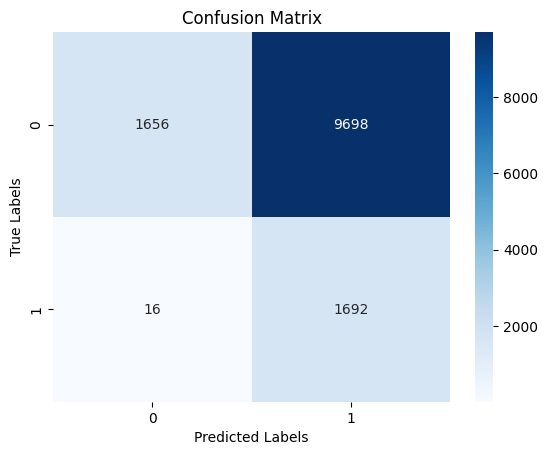

Accuracy :25.63160312356454%
Epoch 138/150, Loss: 0.6889208555221558


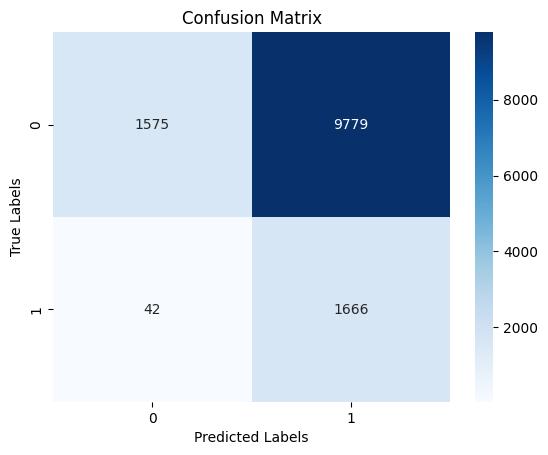

Accuracy :24.812433011789924%
Epoch 139/150, Loss: 0.6939740180969238


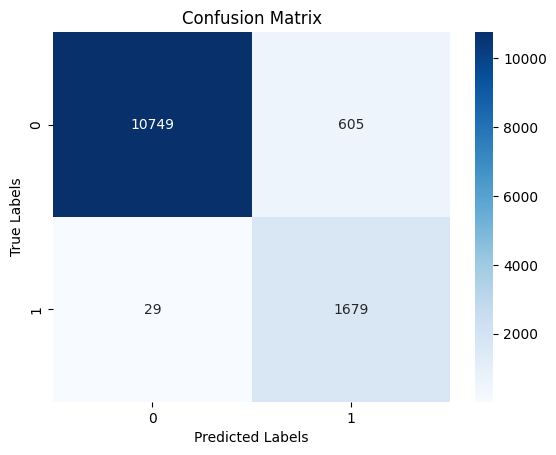

Accuracy :95.14622569284948%
Epoch 140/150, Loss: 0.6893067359924316


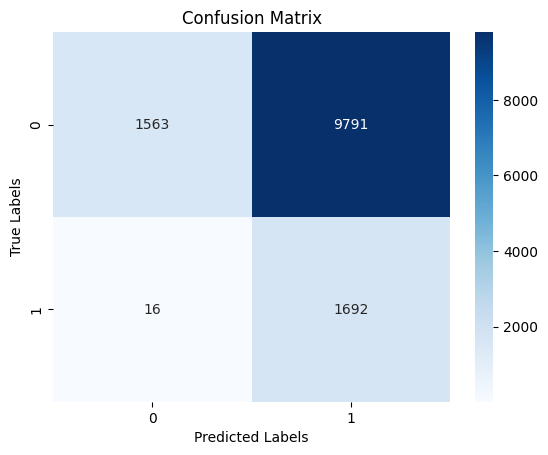

Accuracy :24.919614147909968%
Epoch 141/150, Loss: 0.6929435729980469


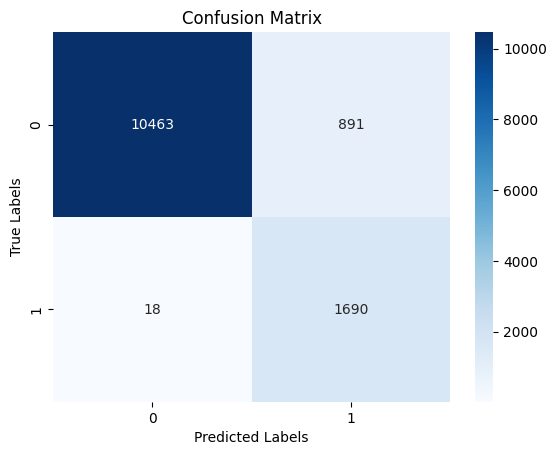

Accuracy :93.04088194763436%
Epoch 142/150, Loss: 0.6899852752685547


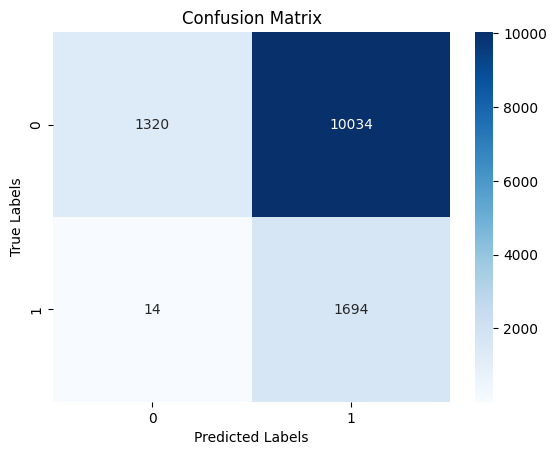

Accuracy :23.0745674475578%
Epoch 143/150, Loss: 0.6889848709106445


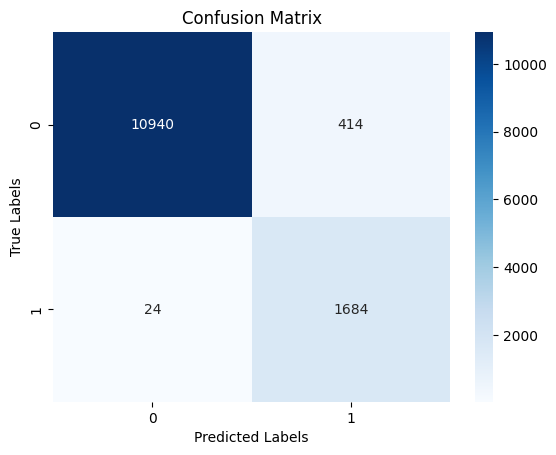

Accuracy :96.64676159853009%
Epoch 144/150, Loss: 0.6893458366394043


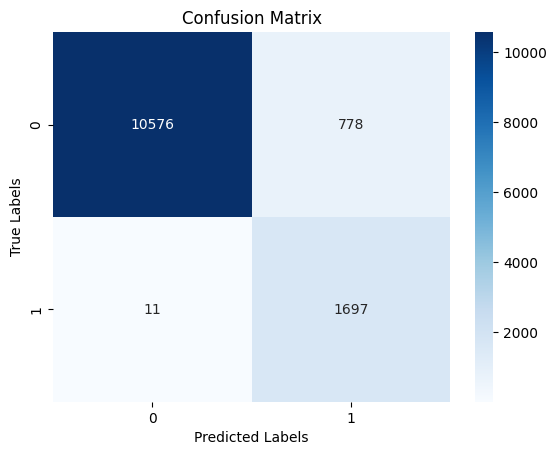

Accuracy :93.95957740009186%
Epoch 145/150, Loss: 0.6907225847244263


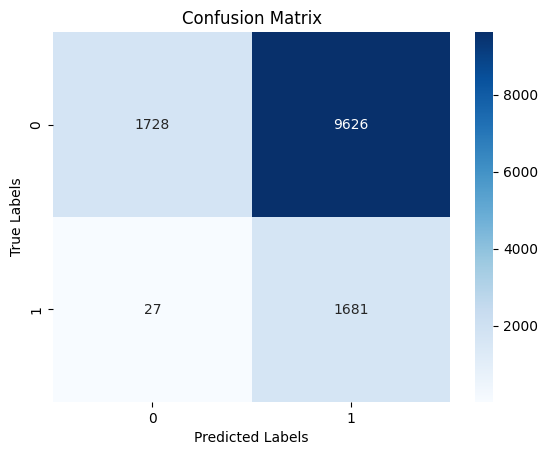

Accuracy :26.098606645230436%
Epoch 146/150, Loss: 0.6931793093681335


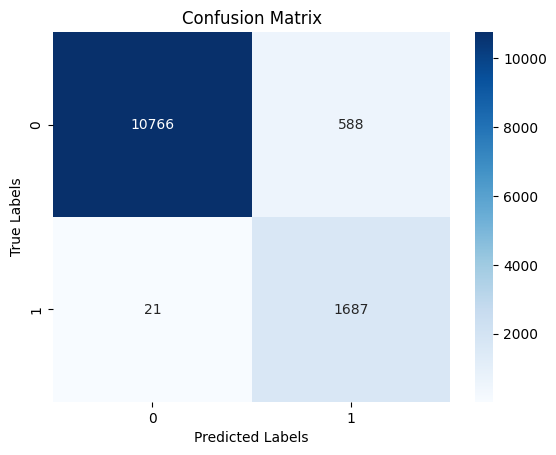

Accuracy :95.33762057877814%
Epoch 147/150, Loss: 0.6838582754135132


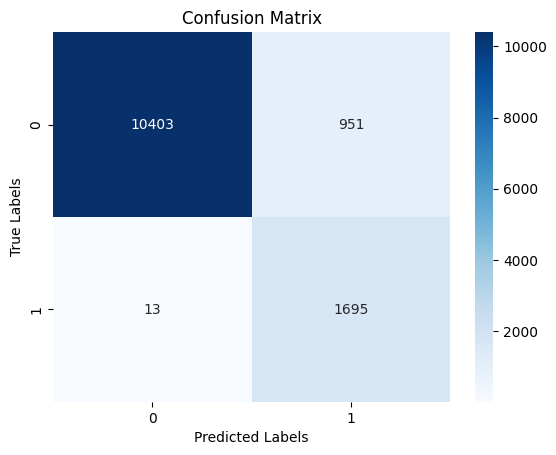

Accuracy :92.61981319859134%
Epoch 148/150, Loss: 0.6816271543502808


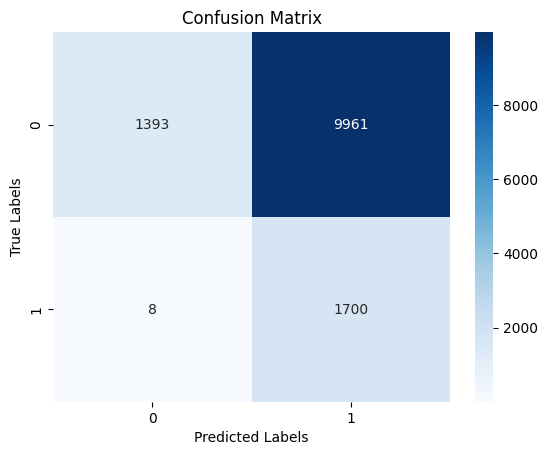

Accuracy :23.67937528709233%
Epoch 149/150, Loss: 0.6891064047813416


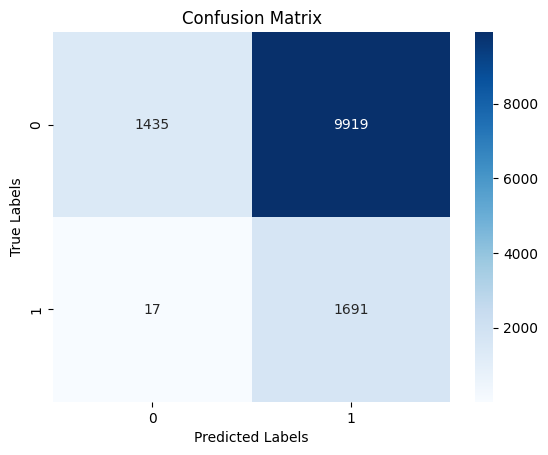

Accuracy :23.932016536518145%
Epoch 150/150, Loss: 0.688683271408081


In [ ]:
# Define a function to reset the model and optimizer
def reset_model_and_optimizer():
    model.apply(weight_reset)  # Reset model parameters to initial state
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Reinitialize optimizer
    model.to(device)  # Move model to the appropriate device

# Weight reset function to be used with model.apply()
def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()

plot_accuracy = []
plot_loss = []

best_model_epoch = 0
num_epochs = 150
save_interval = 30

for epoch in range(num_epochs):
    for inputs, targets in training_dataloader:
        inputs = inputs.to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)
        # Forward pass
        outputs = model(inputs)
        # Reshape the target tensor
        targets = targets.view(-1, 2)

        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    round_loss, round_accuracy = test(model, test_dataloader, criterion)
    plot_loss.append(round_loss)
    plot_accuracy.append(round_accuracy)

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Perform validation on the validation dataset and calculate accuracy
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for val_inputs, val_targets in test_dataloader:
            val_inputs = val_inputs.to(torch.float32).to(device)
            val_targets = val_targets.to(torch.float32).to(device)

            check_label = torch.Tensor()
            check_label = torch.argmax(val_targets, dim=1)

            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs.data, 1)
            total_samples += val_targets.size(0)
            total_correct += (predicted == check_label).sum().item()
        validation_accuracy = total_correct / total_samples

    # Save the model checkpoint only if it's better than the previous best
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch + 1,
            'best_accuracy': best_accuracy,
            # Add any other information you want to save
        }, '/content/drive/MyDrive/專題/Kong model/best_model.pth')
        best_model_epoch = epoch+1
        print(f'Best model saved, epoch = {epoch+1}.')

    # Save the model checkpoint every 20 epochs
    if (epoch + 1) % save_interval == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch + 1,
            'best_accuracy': best_accuracy,
            # Add any other information you want to save
        }, f'/content/drive/MyDrive/專題/Kong model/checkpoint_epoch_{epoch+1}.pth')
        reset_model_and_optimizer()


# Accuracy

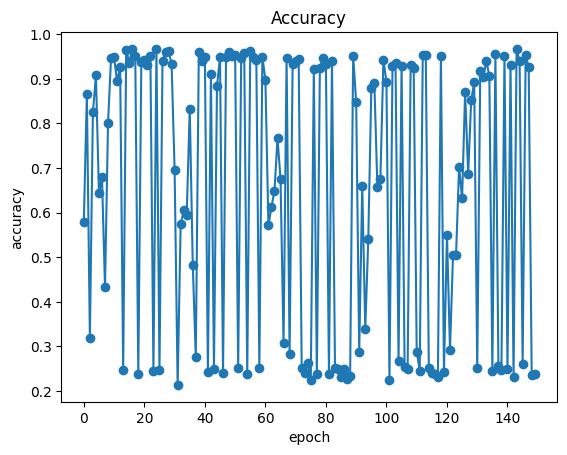

In [ ]:
import matplotlib.pyplot as plt

# Generate x-axis values (0 to len(data) - 1)
accuracy_x = range(len(plot_accuracy))

# Plot the data as a line chart
plt.plot(accuracy_x, plot_accuracy, marker='o')

# Add labels and title
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')

# Display the chart
plt.show()


# Loss

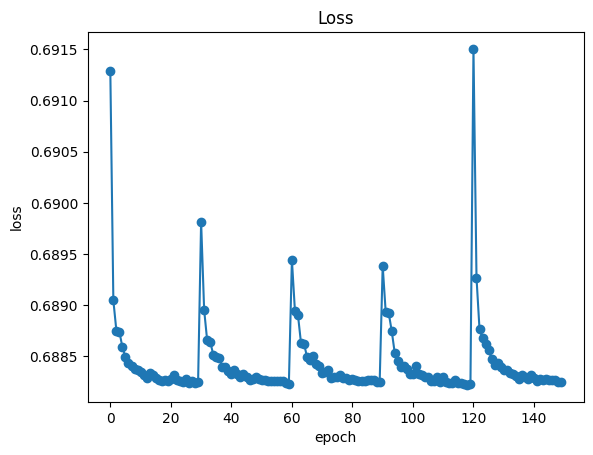

In [ ]:
# Generate x-axis values (0 to len(data) - 1)
loss_x = range(len(plot_loss))

# Plot the data as a line chart
plt.plot(loss_x, plot_loss, marker='o')

# Add labels and title
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

# Display the chart
plt.show()


# Check best model

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/專題/Kong model/best_model.pth')

print(best_model_epoch)

17


In [ ]:
model = Majhong_Model()
model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
model.eval()

Majhong_Model(
  (conv1): Conv1d(2, 256, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
  (conv_last): Conv1d(256, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

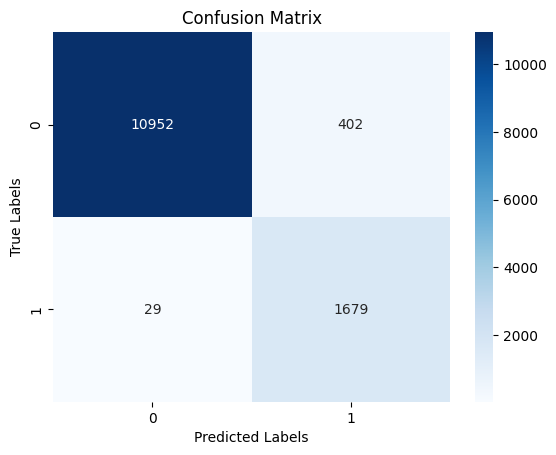

Accuracy :96.70035216659011%


(0.6882729270596578, 0.9670035216659011)

In [ ]:
test(model, test_dataloader, criterion)
